In [1]:
import numpy 
import scipy
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 32
%matplotlib inline
from matplotlib import rc
rc('font',**{'family':'verdana', 'size':32})

In [2]:
def init_from_0(P_0, M, T_0, kappa):
    R = 287.0
    T_ini = T_0 / (1 + (kappa - 1) * M**2 / 2)
    P_ini = P_0 / ((1 + (kappa - 1) * M**2 / 2)**(kappa / (kappa - 1)))
    print((1 + (kappa - 1) * M**2 / 2)**(kappa / (kappa - 1)))
    d_ini = P_ini / R / T_ini
#    u_ini = (kappa * P_ini * M / d_ini)**0.5
    u_ini = (kappa * P_ini / d_ini)**0.5 * M
    return([P_ini, u_ini, T_ini, d_ini])

In [3]:
name_add = '1037'#1040 
time_cold = 227 #179
time_hot = 269 #225
P_0_cam = 15.02 * 98066.5 #14.83
T_0_cam = 1738 #1720

In [4]:
def area(x_arr, f_name):
    nuz=numpy.loadtxt(f_name)
  
    y_coord_noz = nuz[:, 1]
    x_coord_noz = nuz[:, 0]
    x_coord_noz[0] = 0
    y_new = numpy.interp(x_arr, x_coord_noz, y_coord_noz)
    F[:] = abs(y_new[:] * 2.0 * 0.1)
    lenth = numpy.zeros_like(y_new)
    lenth[0] = 0
    s = numpy.zeros_like(y_new)
    lenth[1:] = ((abs(y_new[:-1] - y_new[1:]))**2 + (abs(x_arr[:-1] - x_arr[1:]))**2)**0.5
    for i in range(len(lenth) - 1):
        s[i+1] = s[i] + lenth[i+1] 
    #print(y_new[-1])
    #pyplot.plot(x_arr, y_new)
    numpy.savetxt('s.txt', s)
    return F

In [5]:
x = numpy.linspace(0, 1.65, num=50000)
x_cc = numpy.linspace(0, 1.5, num=50000)
#F=numpy.ones_like(x)#заготовка под канал постоянного сечения 
F = numpy.zeros_like(x)

F = area(x, 'wall_new.txt')
#print(F[-5:-1])
u_0 = numpy.zeros(4)
#u_0 = numpy.zeros(4)
u_0_new = init_from_0(14.8 * 98066.5, 1.01, 1650, 1.3)#давление,мах,температура торможения,плотность

u_0 = u_0_new
print(u_0)
#u_0 = [820080, 798.314, 1691.22, 1.68956]

1.8533245614477456
[783124.6777770185, 738.0036194872569, 1431.0308192000973, 1.9067775321445863]


In [6]:
change_zero_point = numpy.ones_like(x)
change_zero_point *= -145
#print(change_zero_point+numpy.ones_like(x))

In [7]:
def Quasi1D_without_burn(u0, F, Tw_int):
    print('selected Eu1')
    s = numpy.loadtxt('s.txt')  # axe along chamber's wall
    kappa = 1.3
    L0 = 14.35
    mu_0 = 18.27 * 1e-6
    T_0 = 291.15
    Cp = 1244
    Tw = Tw_int
    for j in range(len(F)):
        if x[j] <= 0.145:
            Tw[j] = 900
    pyplot.plot(x, Tw)
    #Tw = numpy.ones_like(F) * 800 #initial value for all Chamber
    Tw_norm = numpy.zeros_like(F)
    Cf = numpy.zeros_like(F)
    tau_w = numpy.zeros_like(F)
    x_n = numpy.zeros_like(F)
    X = numpy.zeros_like(F)
    delta = numpy.zeros_like(F)
    q = numpy.zeros_like(F)
    alpha = 3.2
    u = numpy.zeros((4, len(F)))
    print(u.shape)
    h = 1.65 / len(F)  #for channel with constant area
    u[:, 0] = u0[:]
    flag=0
    for i in range(0, len(F) - 1 ):
        Mach_sq = u[1, i]**2 * u[3, i] / (u[0, i] * kappa)
        Tw_norm[i] = Tw[i] / (u[2, i] * (1 + 0.72**(1 / 3) * (kappa - 1) * 0.5 * Mach_sq))
        A = (1 + (kappa - 1) * 0.5 * Mach_sq)**0.6 / (1 + (kappa - 1) * 0.375 * Mach_sq)**1.05 \
            * Tw_norm[i]**0.6 * (2 / (1 + Tw_norm[i]))**1.05
        u_n = u.copy()
        #print(A)
        mu = mu_0 * (T_0 + 120) / (u[2, i] + 120) * (u[2, i] / T_0)**1.5
        #print(mu)
        delta_star_delta  = 1 - int_1(Mach_sq, kappa, Tw_norm[i], 7)
        delta_dstar_delta = 1 - delta_star_delta - int_2(Mach_sq, kappa, Tw_norm[i], 7)
        #print(delta_dstar_delta)
        #x_n[i] = (delta[i] / 0.0575 * delta_dstar_delta**(-0.8) / (u[3, i] * u[1, i] / mu)**0.2 * A)**1.25
        x_n[i] = (delta[i] / (0.0575 * delta_dstar_delta**(-0.8) / (u[3, i] * u[1, i] / mu)**0.2 * A))**1.25
        if i < len(F) - 1:#сделанно для избежания выхода за границу массива.
            delta[i+1] = s[i+1] * 0.0575 * delta_dstar_delta**(-0.8) / (u[3, i] * u[1, i] * s[i+1] / mu)**0.2 * A
        else:
            delta[i] = 0.
        if i == 0:# начало описания трения
            Cf[i] = 0
        else:
            Cf[i] = 0.0922 * delta_dstar_delta**0.2 / (u[3, i] * u[1, i] * x_n[i] / mu)**0.2 * A
        #print(Cf[i], s[i])
        tau_w[i] = Cf[i] * 0.5 * u[3, i] * u[1, i]**2
        X[i] = tau_w[i] * 0.1 
        #print(Cf[i])
       # if x[i] <= 0.145:
        if x[i] <= 0.145:  #for const_area_channel
            q[i] = 0.0
        else:
            #print ('подача',x[i])
         #   q[i] =  1 / (1 + alpha*L0) * (Q_add[i] - Q_add[i-1]) / h
            q[i] = -0.05 * Cf[i] * Cp * u[3, i] * u[1, i] * (u[2, i] * (1 + 0.5 * (kappa - 1) * Mach_sq) - Tw[i]) \
                   / (u[3, i] * u[1, i] * F[i]) #+ 1 / (1 + alpha*L0) * (Q_add[i] - Q_add[i-1]) / h
            #q[i] = 0.05 * Cf[i] * Cp * u[3, i] * F[i] * (u[2, i] * (1 + 0.5 * (kappa - 1) * Mach_sq) - Tw[i])
   #     if (x[i] >= 0.325) and (flag==0):
   #         print('kek')
   #         p_old =u[0,i]
   #         u_old =u[1,i]
   #         ro_old=u[3,i]
   #         G_old=F[i-1] * u[1, i] * u[3, i]
   #         A=G_old+G_old/(14.5*alpha)
   #         B=ro_old*u_old*u_old+p_old
   #         Ret=296#tyt error
   #         T_0_etilena=280#error
   #         kappa_et=1.24
   #         C=G_old*(u_old*u_old/2+kappa*p_old/(kappa-1)/ro_old)+G_old/(14.5*alpha)*kappa_et/(kappa_et-1)*Ret*T_0_etilena
   #         a=(0.5-kappa/(kappa-1))
   #         b=(kappa*B*F[i]/(kappa-1)/A)
   #         c=-C/A
   #         D=b*b-4*a*c
   #         u_new=(-b-D**0.5)/(2*a)
   #         ro_new=A/(u_new*F[i])
   #         p_new=B-ro_new*u_new**2
   #         u[0, i]=p_new
   #         u[1, i]=u_new
   #         #u[2, i]=T_new
   #         u[3, i]=ro_new
   #         flag=1
   #         
      #  if flag==1:
      #      q[i]+=Q_add[i]
            
            
        u[0, i+1] = u[0, i] * (1 + h * Mach_sq * kappa / (1 - Mach_sq) * ((F[i+1] - F[i]) / (h * F[i]) - q[i] \
                    / (u[2, i] * Cp) - (1 + (kappa - 1) * Mach_sq) * X[i] / (kappa * Mach_sq * F[i] * u[0, i])))
        u[1, i+1] = u[1, i] * (1 - h / (1 - Mach_sq) * ((F[i+1] - F[i]) / (h * F[i]) - q[i] \
                    / (u[2, i] * Cp) - (X[i]) / (F[i] * u[0, i])))
        u[2, i+1] = u[2, i] * (1 + h / (1 - Mach_sq) * ((kappa - 1) * Mach_sq * (F[i+1] - F[i]) / (h * F[i]) + (1 - kappa * Mach_sq) \
                    * q[i] / (u[2, i] * Cp) - (kappa - 1) * Mach_sq * X[i] / (F[i] * u[0, i])))
        u[3, i+1] = u[3, i] * (1 + h / (1 - Mach_sq) * (Mach_sq * (F[i+1] - F[i]) / (h * F[i]) - q[i] \
                    / (u[2, i] * Cp) - X[i] / (F[i] * u[0, i])))
        #print(u[0, i] * (1 + h * Mach_sq * kappa / (1 - Mach_sq) * ((F[i+1] - F[i])/(h* F[i]))))
        #print(u[:, i+1])
      #  u_res[:,i] = u[:]
    def Int_q(q, h):
        delt = numpy.zeros(len(q) -1)
        delt[:] = (q[1:] + q[:-1]) * h * 0.5
        return delt
    IntQ = numpy.zeros(len(F))
    for k in range(1, len(F)):
        IntQ[k] = IntQ[k-1] + Int_q(q, h)[k-1]
   # print (q[40000],Q_add[40000])
    numpy.savetxt('result_without_burn' + name_add + '.txt', u)
    numpy.savetxt('q_without_burn(x)' + name_add + '.txt', IntQ)
    return u

In [8]:
def Quasi1D_burn_cold(u0, F, P_ave, Tw_int):
    print('selected Eu1')
    s = numpy.loadtxt('s.txt')
    kappa = 1.3
    L0 = 14.35
    mu_0 = 18.27 * 1e-6
    T_0 = 291.15
    Cp = 1244
    Tw = Tw_int
    for j in range(len(F)):
        if x[j] <= 0.145:
            Tw[j] = 900
    pyplot.plot(x, Tw)
    #Tw = numpy.ones_like(F) * 800 #initial value for all Chamber
    Tw_norm = numpy.zeros_like(F)
    Cf = numpy.zeros_like(F)
    tau_w = numpy.zeros_like(F)
    x_n = numpy.zeros_like(F)
    X = numpy.zeros_like(F)
    delta = numpy.zeros_like(F)
    q = numpy.zeros_like(F)
    q_wall = numpy.zeros_like(F)
    q_chem = numpy.zeros_like(F)
    alpha = 3.2
    u = numpy.zeros((4, len(F)))
    print(u.shape)
    h = 1.65 / len(F)
    u[:, 0] = u0[:]
    flag = 0
    for i in range(0, len(F) - 1 ):
        Mach_sq = u[1, i]**2 * u[3, i] / (u[0, i] * kappa)
        Tw_norm[i] = Tw[i] / (u[2, i] * (1 + 0.72**(1/3) * (kappa - 1) * 0.5 * Mach_sq))
        A = (1 + (kappa - 1) * 0.5 * Mach_sq)**0.6 / (1 + (kappa - 1) * 0.375 * Mach_sq)**1.05 \
            * Tw_norm[i]**0.6 * (2 / (1 + Tw_norm[i]))**1.05
        u_n = u.copy()
        #print(A)
        mu = mu_0 * (T_0 + 120) / (u[2, i] + 120) * (u[2, i] / T_0)**1.5
        #print(mu)
        delta_star_delta  = 1 - int_1(Mach_sq, kappa, Tw_norm[i], 7)
        delta_dstar_delta = 1 - delta_star_delta - int_2(Mach_sq, kappa, Tw_norm[i], 7)
        #print(delta_dstar_delta)
        #x_n[i] = (delta[i] / 0.0575 * delta_dstar_delta**(-0.8) / (u[3, i] * u[1, i] / mu)**0.2 * A)**1.25
        x_n[i] = (delta[i] / (0.0575 * delta_dstar_delta**(-0.8) / (u[3, i] * u[1, i] / mu)**0.2 * A))**1.25
        if i < len(F) - 1:#сделанно для избежания выхода за границу массива.
            delta[i+1] = s[i+1] * 0.0575 * delta_dstar_delta**(-0.8) / (u[3, i] * u[1, i] * s[i+1] / mu)**0.2 * A
        else:
            delta[i] = 0.
        if i == 0:# начало описания трения
            Cf[i] = 0
        else:
            Cf[i] = 0.0922 * delta_dstar_delta**0.2 / (u[3, i] * u[1, i] * x_n[i] / mu)**0.2 * A
        #print(Cf[i], s[i])
        tau_w[i] = Cf[i] * 0.5 * u[3, i] * u[1, i]**2
        X[i] = tau_w[i] * 0.1 
        #print(Cf[i])
        if x[i] <= 0.145:
            q[i] = 0.
        elif (x[i] > 0.145):
            #print ('подача',x[i])
            #q[i] =  1 / (1 + alpha*L0) * (Q_add[i] - Q_add[i-1]) / h
            if x[i] < 0.325:
                q[i] = -0.05 * Cf[i] * Cp * u[3, i] * u[1, i] * (u[2, i] * (1 + 0.5 * (kappa - 1) * Mach_sq) - Tw[i]) \
                       / (u[3, i] * u[1, i] * F[i])
         
            q_wall[i] = -0.05 * Cf[i] * Cp * u[3, i] * u[1, i] * (u[2, i] * (1 + 0.5 * (kappa - 1) * Mach_sq) - Tw[i]) \
                        / (u[3, i] * u[1, i] * F[i])
            #q[i] = 0.05 * Cf[i] * Cp * u[3, i] * F[i] * (u[2, i] * (1 + 0.5 * (kappa - 1) * Mach_sq) - Tw[i])
        if (x[i] >= 0.325) and (flag == 0):
            print('kek')
         #   p_old =u[0,i]
         #   u_old =u[1,i]
         #   ro_old=u[3,i]
         #   G_old=F[i] * u[1, i] * u[3, i]
         #   A=G_old+G_old/(14.8*alpha)
         #   B=ro_old*u_old*u_old+p_old
         #   Ret=297 #tyt net error
         #   T_0_etilena=291  
         #   kappa_et=1.24
         #   C=G_old*(u_old*u_old/2+kappa*p_old/(kappa-1)/ro_old)+G_old/(14.5*alpha)*kappa_et/(kappa_et-1)*Ret*T_0_etilena
         #   a=(0.5-kappa/(kappa-1))
         #   b=(kappa*B*F[i]/(kappa-1)/A)
         #   c=-C/A
         #   D=b*b-4*a*c
         #   u_new=(-b-D**0.5)/(2*a)
         #   ro_new=A/(u_new*F[i])
         #   p_new=B-ro_new*u_new**2
         #   u[0, i]=p_new
         #   u[1, i]=u_new
         #   #u[2, i]=T_new
         #   u[3, i]=ro_new
            flag = 1            
            u[0, i:] = P_ave[:]
            
        if (x[i] >= 0.325):
            q[i] = ((F[i+1] - F[i]) / (h * F[i]) - (1 + (kappa - 1) * Mach_sq) * X[i] / (kappa * Mach_sq * F[i] * u[0, i]) \
               - (u[0, i+1] - u[0, i-1]) / (2 * h * u[0, i]) * (1 - Mach_sq) / Mach_sq * kappa) * u[2, i] * Cp                  
            
            u[1, i+1] = u[1, i] * (1 - h / (1 - Mach_sq) * ((F[i+1] - F[i]) / (h * F[i]) - q[i] \
                        / (u[2, i] * Cp) - X[i] / (F[i] * u[0, i])))
            u[2, i+1] = u[2, i] * (1 + h / (1 - Mach_sq) * ((kappa - 1) * Mach_sq * (F[i+1] - F[i]) / (h * F[i]) + (1 - kappa * Mach_sq) \
                        * q[i] / (u[2, i] * Cp) - (kappa - 1) * Mach_sq * X[i] / (F[i] * u[0, i])))
            u[3, i+1] = u[3, i] * (1 + h / (1 - Mach_sq) * (Mach_sq * (F[i+1] - F[i]) / (h * F[i]) - q[i] \
                        / (u[2, i] * Cp) - X[i] / (F[i] * u[0, i])))
        else:
            u[0, i+1] = u[0, i] * (1 + h * Mach_sq * kappa / (1 - Mach_sq) * ((F[i+1] - F[i]) / (h * F[i]) - q[i] \
                        / (u[2, i] * Cp) - (1 + (kappa - 1) * Mach_sq) * X[i] / (kappa * Mach_sq * F[i] * u[0, i])))
            u[1, i+1] = u[1, i] * (1 - h / (1 - Mach_sq) * ((F[i+1] - F[i]) / (h * F[i]) - q[i] \
                        / (u[2, i] * Cp) - X[i] / (F[i] * u[0, i])))
            u[2, i+1] = u[2, i] * (1 + h / (1 - Mach_sq) * ((kappa - 1) * Mach_sq * (F[i+1] - F[i]) / (h * F[i]) + (1 - kappa * Mach_sq) \
                        * q[i] / (u[2, i] * Cp) - (kappa - 1) * Mach_sq * X[i] / (F[i] * u[0, i])))
            u[3, i+1] = u[3, i] * (1 + h / (1 - Mach_sq) * (Mach_sq * (F[i+1] - F[i]) / (h * F[i]) - q[i] \
                        / (u[2, i] * Cp) - X[i] / (F[i] * u[0, i])))
        
        #print(u[0, i] * (1 + h * Mach_sq * kappa / (1 - Mach_sq) * ((F[i+1] - F[i])/(h* F[i]))))
        #print(u[:, i+1])
      #  u_res[:,i] = u[:]
    def Int_q(q, h):
        delt = numpy.zeros(len(q) - 1)
        delt[:] = (q[1:] + q[:-1]) * h * 0.5
        return delt
    IntQ = numpy.zeros((4, len(F)))
    q_chem[:] = q[:] - q_wall[:]
    
    for k in range(1, len(F)):
        IntQ[0, k] = IntQ[0, k-1] + Int_q(q, h)[k-1]
        IntQ[1, k] = IntQ[1, k-1] + Int_q(q_wall, h)[k-1]
        IntQ[2, k] = IntQ[2, k-1] + Int_q(q_chem, h)[k-1]
        IntQ[3, k] = IntQ[3, k-1] + Int_q(Cf, h)[k-1]
    
    
   # print (q[40000],Q_add[40000])
    numpy.savetxt('Q(x)_cold_burn' + name_add + '.txt', IntQ)
    numpy.savetxt('result_cold_burn' + name_add + '.txt', u)
    return u

In [28]:
def Quasi1D(u0, F, P_ave, Tw_int):
    print('selected Eu1')
    s = numpy.loadtxt('s.txt')
    kappa = 1.3
    L0 = 14.35
    mu_0 = 18.27 * 1e-6
    T_0 = 291.15
    Cp = 1244
    Tw = Tw_int
    for j in range(len(F)):
        if x[j] <= 0.145:
            Tw[j] = 900
    pyplot.plot(x, Tw)
    #Tw = numpy.ones_like(F) * 800 #initial value for all Chamber
    Tw_norm = numpy.zeros_like(F)
    
    ###data for eta#####
    Fn = numpy.zeros_like(F)
    Fn[0] = F[0]
    Mach_sq0 = 0.0
    
    pseudo_s = 0
    pseudo_f = 0
    for j in range(1, len(P_ave))[::-1]:
        if P_ave[j] - P_ave[j-1] > 0:
            pseudo_s = j
        if P_ave[j] > P_ave[pseudo_f]:
            pseudo_f = j
            
    ###################
    Cf = numpy.zeros_like(F)
    tau_w = numpy.zeros_like(F)
    x_n = numpy.zeros_like(F)
    X = numpy.zeros_like(F)
    delta = numpy.zeros_like(F)
    q = numpy.zeros_like(F)
    q_wall = numpy.zeros_like(F)
    q_chem = numpy.zeros_like(F)
    alpha = 3.2
    u = numpy.zeros((4, len(F)))
    print(u.shape)
    h = 1.65 / len(F)
    u[:, 0] = u0[:]
    flag = 0
    for i in range(0, len(F) - 1):
        Mach_sq = u[1, i]**2 * u[3, i] / (u[0, i] * kappa)
        Tw_norm[i] = Tw[i] / (u[2, i] * (1 + 0.72**(1/3) * (kappa - 1) * 0.5 * Mach_sq))
        A = (1 + (kappa - 1) * 0.5 * Mach_sq)**0.6 / (1 + (kappa - 1) * 0.375 * Mach_sq)**1.05 \
            * Tw_norm[i]**0.6 * (2 / (1 + Tw_norm[i]))**1.05
        u_n = u.copy()
        #print(A)
        mu = mu_0 * (T_0 + 120) / (u[2, i] + 120) * (u[2, i] / T_0)**1.5
        #print(mu)
        delta_star_delta  = 1 - int_1(Mach_sq, kappa, Tw_norm[i], 7)
        delta_dstar_delta = 1 - delta_star_delta - int_2(Mach_sq, kappa, Tw_norm[i], 7)
        #print(delta_dstar_delta)
        #x_n[i] = (delta[i] / 0.0575 * delta_dstar_delta**(-0.8) / (u[3, i] * u[1, i] / mu)**0.2 * A)**1.25
        x_n[i] = (delta[i] / (0.0575 * delta_dstar_delta**(-0.8) / (u[3, i] * u[1, i] / mu)**0.2 * A))**1.25
        if i < len(F) - 1:#сделанно для избежания выхода за границу массива.
            delta[i+1] = s[i+1] * 0.0575 * delta_dstar_delta**(-0.8) / (u[3, i] * u[1, i] * s[i+1] / mu)**0.2 * A
        else:
            delta[i] = 0.
        if i == 0:# начало описания трения
            Cf[i] = 0
        else:
            Cf[i] = 0.0922 * delta_dstar_delta**0.2 / (u[3, i] * u[1, i] * x_n[i] / mu)**0.2 * A
        #print(Cf[i], s[i])
        tau_w[i] = Cf[i] * 0.5 * u[3, i] * u[1, i]**2
        X[i] = tau_w[i] * 0.1 
        #print(Cf[i])
        if x[i] <= 0.145:
            q[i] = 0.
        elif (x[i] > 0.145):
            #print ('подача',x[i])
            #q[i] =  1 / (1 + alpha*L0) * (Q_add[i] - Q_add[i-1]) / h
            if x[i] < 0.325:
                q[i] = -0.05 * Cf[i] * Cp * u[3, i] * u[1, i] * (u[2, i] * (1 + 0.5 * (kappa - 1) * Mach_sq) - Tw[i]) \
                       / (u[3, i] * u[1, i] * F[i])
         
            q_wall[i] = -0.05 * Cf[i] * Cp * u[3, i] * u[1, i] * (u[2, i] * (1 + 0.5 * (kappa - 1) * Mach_sq) - Tw[i]) \
                        / (u[3, i] * u[1, i] * F[i])
            #q[i] = 0.05 * Cf[i] * Cp * u[3, i] * F[i] * (u[2, i] * (1 + 0.5 * (kappa - 1) * Mach_sq) - Tw[i])
        if (x[i] >= 0.325) and (flag == 0):
            print('kek')
            p_old = u[0, i]
            u_old = u[1, i]
            ro_old = u[3, i]
            G_old = F[i] * u[1, i] * u[3, i]
            A = G_old + G_old / (14.8 * alpha)
            B = ro_old * u_old * u_old + p_old
            Ret = 297 #tyt net error
            T_0_etilena = 290 #nado menyat' 
            kappa_et = 1.24
            C = G_old * (u_old * u_old / 2 + kappa * p_old / (kappa - 1) / ro_old) + G_old / (14.5 * alpha) * kappa_et \
                        / (kappa_et - 1) * Ret * T_0_etilena
            print(A, B, C)
            a = 0.5 - kappa / (kappa - 1)
            b = (kappa * B * F[i] / (kappa - 1) / A)
            c = -C / A
            D = b * b - 4 * a * c
            u_new = (-b - D**0.5) / (2 * a)
            ro_new = A / (u_new * F[i])
            p_new = B - ro_new * u_new**2
            u[0, i] = p_new
            u[1, i] = u_new
            #u[2, i]=T_new
            u[3, i] = ro_new
            flag = 1            
            u[0, i:] = P_ave[:]
            
            pseudo_s += i
            pseudo_f += i
            
        ###################################
        # this is an attempt to make eta  #
        ###################################
        if ((i >= pseudo_s) and (i <= pseudo_f) and (flag == 1)):
            if (i == pseudo_s):
                Mach_sq0 = Mach_sq
                Fn[i] = F[i]
            Qwall = 0.0
            for j in range(pseudo_s, i):
                Qwall = Qwall + abs(q_wall[j] * h * 0.1)
            deltaTwall = Qwall / Cp
            k_star_rev = u[2, i] * (1 + (kappa - 1) * 0.5 * Mach_sq) \
                        / (u[2, i] * (1 + (kappa - 1) * 0.5 * Mach_sq) - abs(deltaTwall))
            K_frict = 0.8 * Cf[i] * x[i] * 0.1 * kappa * u[0, i] * Mach_sq / (2 * F[i])#!!!check for 0.1=z
            f_fact = F[i] / F[pseudo_s]
            p_fact = u[0, i] / u[0, pseudo_s]
            eta = (((1 - f_fact * K_frict) * (1 + kappa * Mach_sq0) - p_fact * f_fact) / (kappa * Mach_sq0)) * k_star_rev \
                        * ((kappa + 1) * p_fact * f_fact + (kappa - 1) * (1 - f_fact * K_frict) * (1 + kappa * Mach_sq0)) \
                        / (2 * kappa * (1 + (kappa - 1) * 0.5 * Mach_sq0))
            Fn[i+1] = F[i+1] / eta**0.5
        else:
            Fn[i+1] = F[i+1]
        ###################################
        #then I just changed F to Fn      #
        ###################################    
            
        if (x[i] >= 0.325):
            Fn[i+1] = F[i+1]
            q[i] = ((F[i+1] - F[i]) / (h * Fn[i]) - (1 + (kappa - 1) * Mach_sq) * X[i] / (kappa * Mach_sq * F[i] * u[0, i]) \
               - (u[0, i+1] - u[0, i-1]) / (2 * h * u[0, i]) * (1 - Mach_sq) / Mach_sq * kappa) * u[2, i] * Cp                  
            
            u[1, i+1] = u[1, i] * (1 - h / (1 - Mach_sq) * ((F[i+1] - Fn[i]) / (h * F[i]) - q[i] \
                        / (u[2, i] * Cp) - X[i] / (F[i] * u[0, i])))
            u[2, i+1] = u[2, i] * (1 + h / (1 - Mach_sq) * ((kappa - 1) * Mach_sq * (F[i+1] - F[i]) / (h * F[i]) + (1 - kappa * Mach_sq) \
                        * q[i] / (u[2, i] * Cp) - (kappa - 1) * Mach_sq * X[i] / (F[i] * u[0, i])))
            u[3, i+1] = u[3, i] * (1 + h / (1 - Mach_sq) * (Mach_sq * (F[i+1] - F[i])/(h* F[i]) - q[i] \
                        / (u[2, i] * Cp) - X[i] / (F[i] * u[0, i])))
            if (i % 500 == 0):
                print(i, ": ", u[0, i], " ", u[1, i], " ", u[2, i], " ", u[3, i])
        else:
            u[0, i+1] = u[0, i] * (1 + h * Mach_sq * kappa / (1 - Mach_sq) * ((Fn[i+1] - Fn[i]) / (h * Fn[i]) - q[i] \
                        / (u[2, i] * Cp) - (1 + (kappa - 1) * Mach_sq) * X[i] / (kappa * Mach_sq * Fn[i] * u[0, i])))
            #print("Mach_sq: ",Mach_sq)
            u[1, i+1] = u[1, i] * (1 - h / (1 - Mach_sq) * ((Fn[i+1] - Fn[i]) / (h * Fn[i]) - q[i] \
                        / (u[2, i] * Cp) - X[i] / (Fn[i] * u[0, i])))
            u[2, i+1] = u[2, i] * (1 + h / (1 - Mach_sq) * ((kappa - 1) * Mach_sq * (Fn[i+1] - Fn[i]) / (h * Fn[i]) + (1 - kappa * Mach_sq) \
                        * q[i] / (u[2, i] * Cp) - (kappa - 1) * Mach_sq * X[i] / (Fn[i] * u[0, i])))
            u[3, i+1] = u[3, i] * (1 + h / (1 - Mach_sq) * (Mach_sq * (Fn[i+1] - Fn[i]) / (h * Fn[i]) - q[i] \
                        / (u[2, i] * Cp) - X[i] / (Fn[i] * u[0, i])))
            if (i % 500 == 0):
                print(i, ": ", u[0, i], " ", u[1, i], " ", u[2, i], " ", u[3, i])
#            if(i <= 1):
#                print(i, ": area, cf, frict: ", h*(F[i+1] - F[i])/(h*F[i]), Cf[i], h*X[i]/(F[i]*u[0,i]))
#                print("xni:", x_n[i])
#                print("A:", A)
#                print("dss/d: ", delta_dstar_delta)
#            else:
#                break
        
        #print(u[0, i] * (1 + h * Mach_sq * kappa / (1 - Mach_sq) * ((F[i+1] - F[i])/(h* F[i]))))
        #print(u[:, i+1])
      #  u_res[:,i] = u[:]
    def Int_q(q, h):
        delt = numpy.zeros(len(q) - 1)
        delt[:] = (q[1:] + q[:-1]) * h * 0.5
        return delt
    IntQ = numpy.zeros((4, len(F)))
    q_chem[:] = q[:] - q_wall[:]
    
    for k in range(1, len(F)):
        IntQ[0, k] = IntQ[0, k-1] + Int_q(q, h)[k-1]
        IntQ[1, k] = IntQ[1, k-1] + Int_q(q_wall, h)[k-1]
        IntQ[2, k] = IntQ[2, k-1] + Int_q(q_chem, h)[k-1]
        IntQ[3, k] = IntQ[3, k-1] + Int_q(Cf, h)[k-1]
    
    
    print (q[40000], Q_add[40000])
    numpy.savetxt('Q(x)' + name_add + '.txt', IntQ)
    numpy.savetxt('u_hot_regime_run' + name_add + '.txt', u)
    
    print("s and f: ", x[pseudo_s], x[pseudo_f])
    wr = open(r"n2.txt", "w")
    for i in range(-1, 50000, 500):
        if i < 0:
            wr.write(str(u[0, 0]) + " " + str(u[1, 0]) + " " + str(u[2, 0]) + " " + str(u[3, 0]) + "\n")   
        else:
            wr.write(str(u[0, i]) + " " + str(u[1, i]) + " " + str(u[2, i]) + " " + str(u[3, i]) + "\n")
    wr.close()     
    return u

In [29]:
def int_1(Mach_sq, kappa, Tw_norm, n):
    z = numpy.linspace(0, 1, num=101)
    f = numpy.zeros_like(z)
    f[:] = z[:]**n / ((1 + 0.5 * (kappa - 1) * Mach_sq) * ((1 - Tw_norm) * z[:] \
           + Tw_norm) - 0.5 * (kappa - 1) * Mach_sq * z[:]**2)
    dz = z[1] - z[0]
    delt = numpy.zeros(len(z) - 1)
    delt[:] = (f[1:] + f[:-1]) * dz * 0.5
    Int = numpy.sum(delt) * n
    return Int

In [30]:
def int_2(Mach_sq, kappa, Tw_norm, n):
    z = numpy.linspace(0, 1, num=101)
    f = numpy.zeros_like(z)
    f[:] = z[:]**(n + 1) / ((1 + 0.5 * (kappa - 1) * Mach_sq) * ((1 - Tw_norm) * z[:] \
           + Tw_norm) - 0.5 * (kappa - 1) * Mach_sq * z[:]**2)
    dz = z[1] - z[0]
    delt = numpy.zeros(len(z) - 1)
    delt[:] = (f[1:] + f[:-1]) * dz * 0.5
    Int = numpy.sum(delt) * n
    return Int

In [31]:
h = 1.65 / len(F)
i=0
while (h * i < 0.325): #ищем номер ячейки подачи топлива
    injection_i = i
    i += 1
    
while (h * i < 0.545): #ищем номер ячейки подачи топлива
    first_point = i
    i += 1
while (h * i < 1.145): #ищем номер ячейки подачи топлива
    second_point = i
    i += 1
print(injection_i)
print(x[first_point])
print(x[second_point])
print(len(x))
print(len(F))
print(injection_i, first_point, second_point, h)
Hu = 49775000  #джоуль на килограмм?
Q_add = numpy.zeros_like(F)
Q_add[injection_i:first_point] = 0.5 * Hu * ((x[injection_i:first_point] - x[injection_i]) / (x[first_point] - x[injection_i]))**2
Q_add[first_point:second_point] = 0.25 * Hu * x[first_point:second_point] / (x[second_point] - x[first_point]) \
            + (0.75 - 0.25 * x[second_point] / (x[second_point] - x[first_point])) * Hu
#print((x[second_point]-x[first_point]))
Q_add[second_point:] = 0.25 * Hu * x[second_point:] / (x[-1] - x[second_point]) \
            + (0.75 - 0.25 * x[second_point] / (x[-1] - x[second_point])) * Hu

9848
0.5450059001180023
1.1449908998179963
50000
50000
9848 16515 34696 3.2999999999999996e-05


In [32]:
k = numpy.loadtxt('T131A_' + name_add + '.txt')#пока просто меняем название файла
time_column = 0
ul = [30, 49]
ur = [50, 68]
dr = [69, 90]
dl = [91, 110]
start_column = 0
finish_column = 1
t_out = [111, 114]
t_in = [115, 119]
x_t_in = [[1230, 1080, 929, 779, 629]]
x_t_out = [[929, 779, 629, 479]]
x_ul = [[105, 360, 450, 516, 591, 658, 748, 816, 890, 958, 1050, 1125, 1200, 1275, 1350, 1500, 1574, 1649, 1724, 1800]]
x_ur = [[105, 142, 292, 360, 450, 516, 658, 748, 816, 958, 1050, 1125, 1200, 1275, 1500, 1574, 1649, 1724, 1800]]
x_dr = [[105, 142, 292, 360, 450, 516, 591, 658, 748, 816, 890, 958, 1050, 1125, 1200, 1275, 1350, 1500, 1574, 1649, 1724, 1800]]
x_dl = [[105, 360, 450, 516, 591, 658, 748, 816, 890, 958, 1050, 1125, 1200, 1275, 1350, 1500, 1574, 1649, 1724, 1800]]
def create_massive_for_graph(k, x_ul, ul):
    test = numpy.append(k[:, (ul[0]-1):(ul[1])], x_ul,axis=0)
    #test2=numpy.zeros_like(test)
    #test2[0,:]=test[-1,:]
    #test2[1:,:]=test[:-1,:]
    #
    #test3=numpy.zeros((1,len(test),len(test2[1,:])))
    #print (len(test2[1,:]))
    #time=k[:,0] 
    ##print (time)
    #time_str=time
    ##print(len(test2[:,]))
    #test4=numpy.transpose(test2) 
    #print (len(test4))
    ##numpy.savetxt('test.dat',test4)
    #print ((test))
    return (test)
k_ul = create_massive_for_graph(k, x_ul, ul)
k_ur = create_massive_for_graph(k, x_ur, ur)
k_dl = create_massive_for_graph(k, x_dl, dl)
k_dr = create_massive_for_graph(k, x_dr, dr)
temp_in = create_massive_for_graph(k, x_t_in, t_in)
temp_out = create_massive_for_graph(k, x_t_out, t_out)

temp_in[:] += 273
temp_out[:] += 273

In [33]:
def delete_bad_numbers(a_x, a):
    k = 0
    while k < len(a):
        if a[k] < 0 or a[k] > 2500:
            a = numpy.delete(a, [k])
            a_x = numpy.delete(a_x, [k])
            k -= 1
        k += 1
        
    k = 1    
    while k < len(a):
        if a[k] < a[k-1]:
            a = numpy.delete(a, [k])
            a_x = numpy.delete(a_x, [k])
            k -= 1
        k += 1

    return(a_x, a)

In [34]:
#print(x_t_in[0][4])
#print(temp_in[261])
def temperature_wall(temp_in, time):
    time -= 1  #time in seconds multiplied by 10
    x_t_int = numpy.zeros_like(temp_in[0])
    Temp_int = numpy.zeros_like(temp_in)
    #print(x_t_int)
    #print(len(x_t_int))
    for j in range (len(x_t_int)):
        #print(x_t_in[0][len(x_t_int) - j - 1])
        x_t_int[j] = (x_t_in[0][len(x_t_int)-j-1] + 145) * 0.001
        Temp_int[:, j] = temp_in[:, len(x_t_int)-j-1]
        
        #print(x_t_int[j])
    print(x_t_int[:])
    print(Temp_int[time])
    x_t_int_new, Temp_int_new = delete_bad_numbers(x_t_int, Temp_int[time])

      
         
    
    
    
  
    Tw = numpy.interp(x, x_t_int, Temp_int[time])
    Tw = numpy.interp(x, x_t_int_new, Temp_int_new)
    #pyplot.plot(x_t_in[0], temp_in[261]);
    pyplot.figure(figsize=(18, 12))
    pyplot.ylim(200, 1000)
    pyplot.grid(True)
    pyplot.plot(x_t_int, Temp_int[time], lw=4);
    pyplot.plot(x, Tw);
    print('finish')
    return (Tw)

In [35]:
def pressure_ave(k_ul, k_ur, k_dr, k_dl, time):
    i = 0
    h = 1.65 / len(x)
    while (h * i < 0.325): #ищем номер ячейки подачи топлива
        injection_i = i
        i += 1
    j = time - 1
    print(len(x))
    #print(j)
    x_ul = [105, 360, 450, 516, 591, 658, 748, 816, 890, 958, 1050, 1125, 1200, 1275, 1350, 1500, 1574, 1649, 1724, 1800]
    x_ur = [105, 142, 292, 360, 450, 516, 658, 748, 816, 958, 1050, 1125, 1200, 1275, 1500, 1574, 1649, 1724, 1800]
    x_dr = [105, 142, 292, 360, 450, 516, 591, 658, 748, 816, 890, 958, 1050, 1125, 1200, 1275, 1350, 1500, 1574, 1649, 1724, 1800]
    x_dl = [105, 360, 450, 516, 591, 658, 748, 816, 890, 958, 1050, 1125, 1200, 1275, 1350, 1500, 1574, 1649, 1724, 1800]    
    costbll = numpy.zeros(50)
    for k in range(len(costbll) - 1):
        costbll[k] = 145
    x_ul[:] = (x_ul[:] + costbll[:len(x_ul)]) * 0.001
    x_ur[:] = (x_ur[:] + costbll[:len(x_ur)]) * 0.001
    x_dl[:] = (x_dl[:] + costbll[:len(x_dl)]) * 0.001
    x_dr[:] = (x_dr[:] + costbll[:len(x_dr)]) * 0.001
    P_ul = numpy.interp(x[i:], x_ul[:], k_ul[j,:] * 98066.5)
    P_ur = numpy.interp(x[i:], x_ur[:], k_ur[j,:] * 98066.5)
    P_dl = numpy.interp(x[i:], x_dr[:], k_dr[j,:] * 98066.5)
    P_dr = numpy.interp(x[i:], x_dl[:], k_dl[j,:] * 98066.5)
    P_ave = numpy.zeros_like(x[i:])
    P_ave[:] = (P_ul[:] + P_ur[:] + P_dr[:] + P_dl[:]) * 0.25
    pyplot.plot(x[i:], P_ave[:])
    print('finish')
    print(len(x[i:]))
    print("inject: ", injection_i)
    return (P_ave)

в выражение для q есть спрятанное домножение на боковую ширину 0,1
в массиве u индекс 0 соответствует давлению, 1 скорости , 2 T температуре а инедкс 3 плотности.

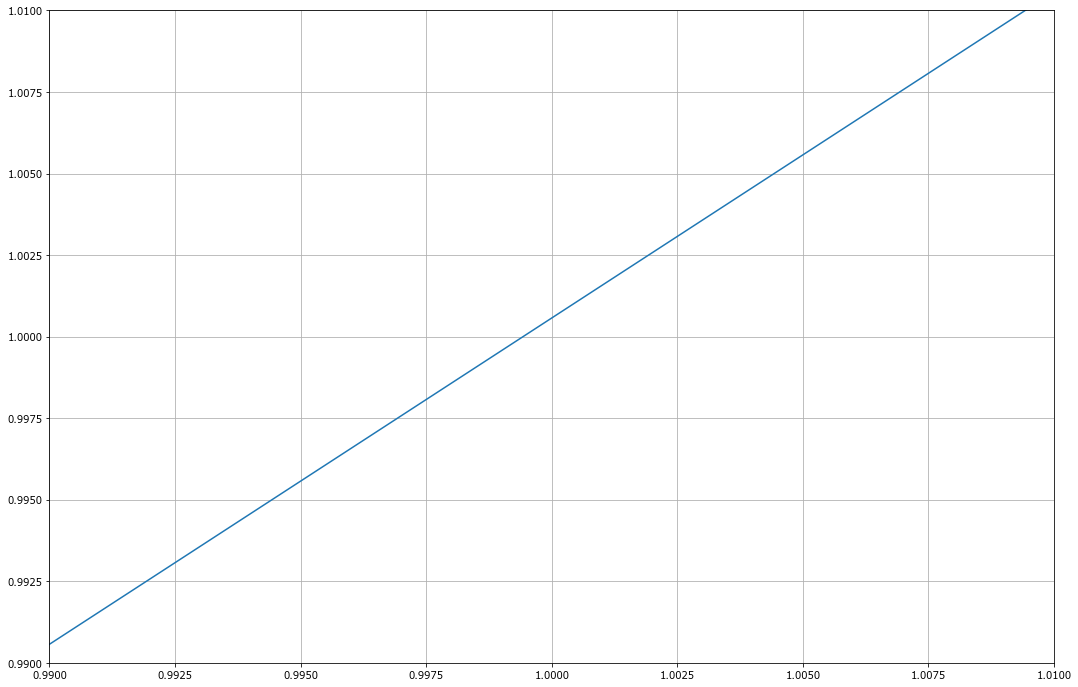

In [36]:
s = numpy.loadtxt('s.txt')

pyplot.figure(figsize=(18,12))
pyplot.grid(True)
pyplot.xlim(0.99, 1.01)
pyplot.ylim(0.99, 1.01)
pyplot.plot(x, s)

50000
finish
40151
inject:  9848
[0.774 0.924 1.074 1.225 1.375]
[727.07913 508.20201 823.72644 321.47681 889.44696]
finish
selected Eu1
(4, 50000)
0 :  783124.6777770185   738.0036194872569   1431.0308192000973   1.9067775321445863
500 :  275101.27629175433   1140.988329996654   1126.9706502696429   0.8515277045197572
1000 :  178183.23199080743   1250.704084021046   1021.3582006124187   0.6086069133186405
1500 :  135478.08979727415   1309.888585398576   960.3581716798737   0.4921477655866859
2000 :  113496.28439981799   1344.5619746417588   923.3097698117115   0.4288433500110767
2500 :  101649.70017525616   1364.6607244493753   901.3907815799058   0.3934225885019057
3000 :  94937.76477890398   1376.3608510309684   888.4811520168605   0.3727844397282764
3500 :  91754.70787211198   1381.6162144358432   882.6466127944767   0.36266751956886123
4000 :  91128.06641524358   1381.8891237863106   882.3430194510329   0.3603146107476053
4500 :  91187.48872575838   1380.823930404912   883.3994551

45000 :  245271.1071353226   780.6417445603367   4455.075514929699   0.38238692324453366
45500 :  237617.0781925167   823.7156703207704   4455.897385275686   0.36238856581114065
46000 :  225705.80137400122   890.9183696112495   4418.290986977944   0.33504917623528546
46500 :  213794.52455548564   958.1054556162501   4335.518336171659   0.3115505777236097
47000 :  201883.2477369702   1025.2764822241525   4211.12376711932   0.2911366552698773
47500 :  189971.97091845458   1092.4309762850685   4048.746915021041   0.2732375483889792
48000 :  178060.69409993896   1159.5684473934514   3852.1330446117354   0.25741562554763975
48500 :  166149.41728142352   1226.6895267782547   3629.119713556123   0.24306274101251424
49000 :  154238.1404629079   1295.0145205462743   3493.3365065446687   0.22267961297315425
49500 :  142326.86364439246   1365.623153961395   3321.5246470546517   0.20445351581704346
69095.634182596 41644237.6494805
s and f:  0.3250565011300226 0.7360137202744055


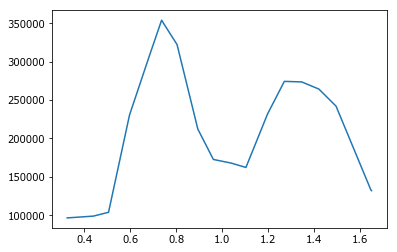

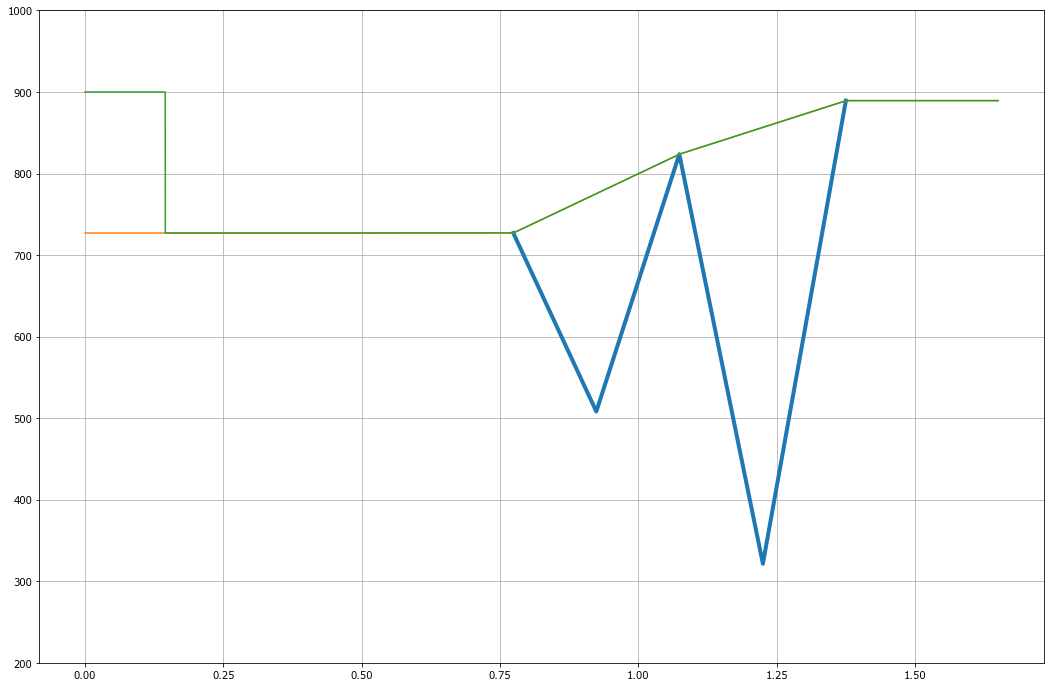

In [37]:
#q = numpy.zeros_like(x)
X = numpy.zeros_like(x)
P_ave = pressure_ave(k_ul, k_ur, k_dr, k_dl, time_hot)
Tw = temperature_wall(temp_in, time_hot)
u = Quasi1D(u_0, F, P_ave, Tw)
#print(u)

In [ ]:
file = open("Tw.txt", "w")
for t in Tw:
        file.write(str(t) + "\n")
file.close()

In [ ]:
wr = open(r"n2.txt", "w")
for i in range(-1, 50000, 500):
    if i < 0:
        wr.write(str(u[0, 0]) + " " + str(u[1, 0]) + " " + str(u[2, 0]) + " " + str(u[3, 0]) + "\n")
    elif i >=49999:        
        wr.write(str(u[0, -1]) + " " + str(u[1, -1]) + " " + str(u[2, -1]) + " " + str(u[3, -1]) + "\n")
    else:
        wr.write(str(u[0, i]) + " " + str(u[1, i]) + " " + str(u[2, i]) + " " + str(u[3, i]) + "\n")
wr.close() 

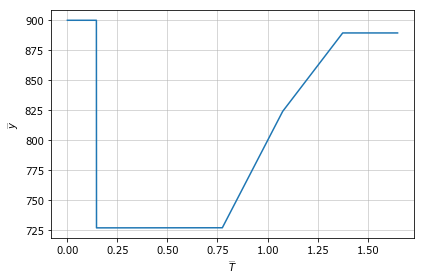

In [21]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)

ax.plot(x, Tw, lw=1.5)
#str(i*len(T_bar)+j+1) + ": 
plt.grid(True, linewidth=0.5)
plt.xlabel('$\widebar{T}$')
plt.ylabel('$\widebar{y}$')
plt.tight_layout()
plt.show()

50000
finish
40151
inject:  9848
[0.774 0.924 1.074 1.225 1.375]
[424.4696  411.54961 765.7012  302.00078 497.48622]
finish
selected Eu1
(4, 50000)
50000
finish
40151
inject:  9848
[0.774 0.924 1.074 1.225 1.375]
[424.4696  411.54961 765.7012  302.00078 497.48622]
finish
selected Eu1
(4, 50000)
kek


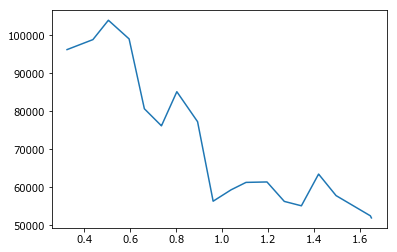

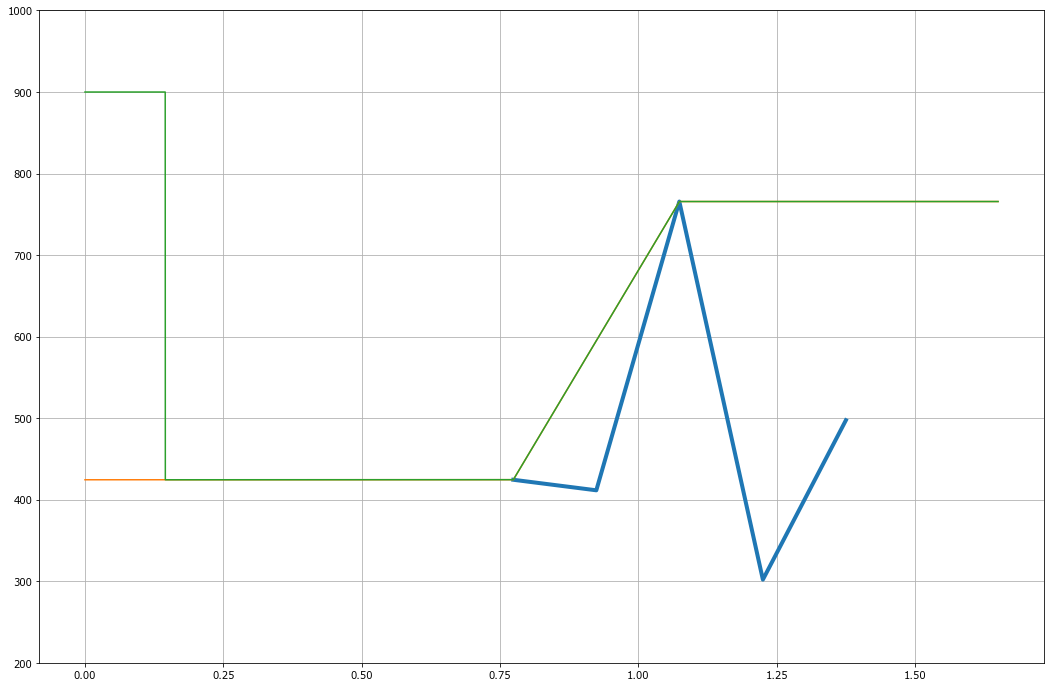

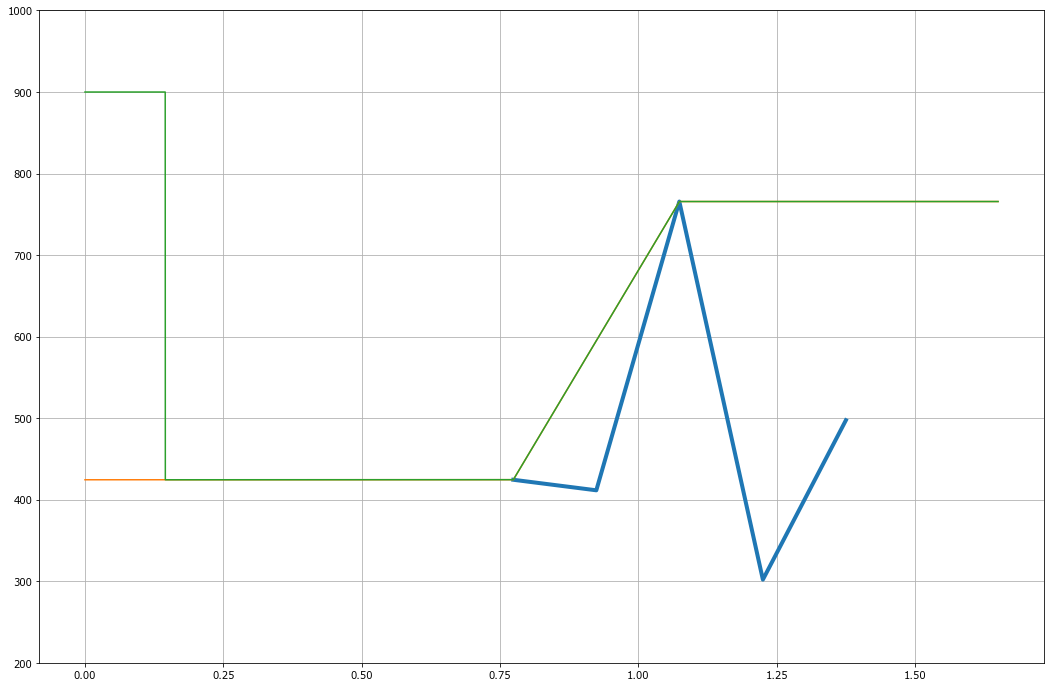

In [22]:
#F_const_channel = numpy.ones(50000) * 0.003
u_0_cc = numpy.zeros(4)
#u_0_without_burn = init_from_0(15*101325, 2.5, 1950, 1.3)
P_ave = pressure_ave(k_ul, k_ur, k_dr, k_dl, time_cold)
Tw = temperature_wall(temp_in, time_cold)
u_without_burn = Quasi1D_without_burn(u_0, F, Tw)
P_ave = pressure_ave(k_ul, k_ur, k_dr, k_dl, time_cold)
Tw = temperature_wall(temp_in, time_cold)
u_cold_burn = Quasi1D_burn_cold(u_0, F, P_ave, Tw)

[1.52224595 1.52224593 1.52224592 1.5222459  1.52224588 1.52224587
 1.52224585 1.52224583 1.52224582 1.5222458  1.52224578 1.52224577
 1.52224575 1.52224573 1.52224572 1.5222457  1.52224568 1.52224567
 1.52224565]


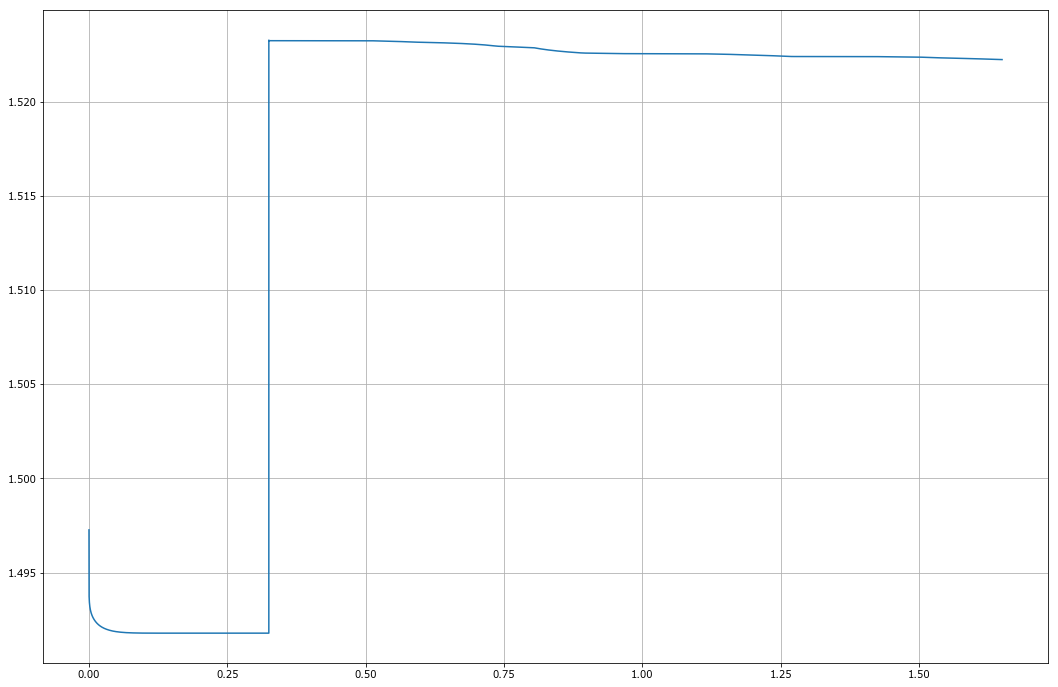

In [23]:
G = numpy.zeros_like(F)
G[:] = F[:] * u[1, :] * u[3, :]
pyplot.figure(figsize=(18, 12))
pyplot.grid(True)
print(G[-20:-1])
pyplot.plot(x, G);

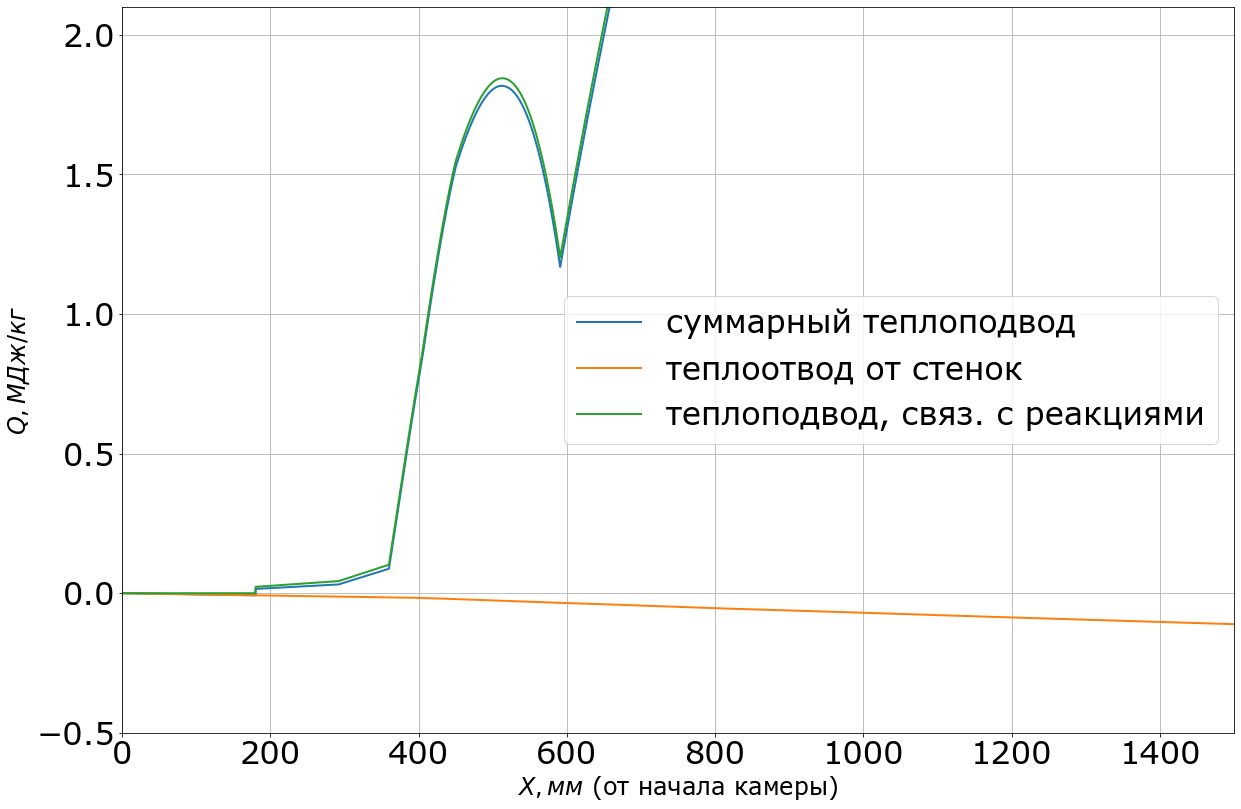

In [24]:
Q = numpy.loadtxt('Q(x)' + name_add + '.txt')
#q_cc = numpy.loadtxt('q_cc(x).txt')
#print(max(Q))
pyplot.figure(figsize=(18, 12))
pyplot.grid(True)
pyplot.xlim(0, 1500)
pyplot.ylim(-0.5, 2.1)
#pyplot.plot(x, u[1, :] / (1.3 * 287 * u[2, :]) ** 0.5);
#pyplot.plot(x, Q_add[:]/10**7);
HU_test = numpy.zeros_like(x)
#HU_test[1:]+=0.5* Hu / (1 + 2.7*14.5) * (Q_add[1:] - Q_add[:-1]) / h
#pyplot.plot(x, HU_test);
#u1=numpy.loadtxt('results_no_injection')
#pyplot.plot(x, u1[1, :] / (1.3 * 287 * u[2, :]) ** 0.5);
#pyplot.plot(x, u[2,:]);
pyplot.xlabel('$X, мм$ (от начала камеры)', fontsize=24)
pyplot.ylabel('$Q, MДж/кг$', fontsize=24)

pyplot.plot(x * 1000 + change_zero_point, Q[0] * 1e-6, lw=2, label='суммарный теплоподвод')
pyplot.plot(x * 1000 + change_zero_point, Q[1] * 1e-6, lw=2, label='теплоотвод от стенок')
pyplot.plot(x * 1000 + change_zero_point, Q[2] * 1e-6, lw=2, label='теплоподвод, связ. с реакциями')
pyplot.legend(loc='best')
#pyplot.plot(x, -622 * u[1, :] * u[3, :] * ((1 - .3/2*u[1, :]**2 / (1.3 * 287 * u[2, :]))* u[2, :] - 800) * Q[3]);
#pyplot.plot(x, - 2.5e7 * Q[3]);
#pyplot.plot(x, - 1.18e5*x**(4/5));
#pyplot.plot(x_cc, q_cc);
#pyplot.plot(x, Q[0] - Q[1]);
pyplot.tight_layout()
pyplot.savefig('Q(x)_hot_regime_run' + name_add + '.png')

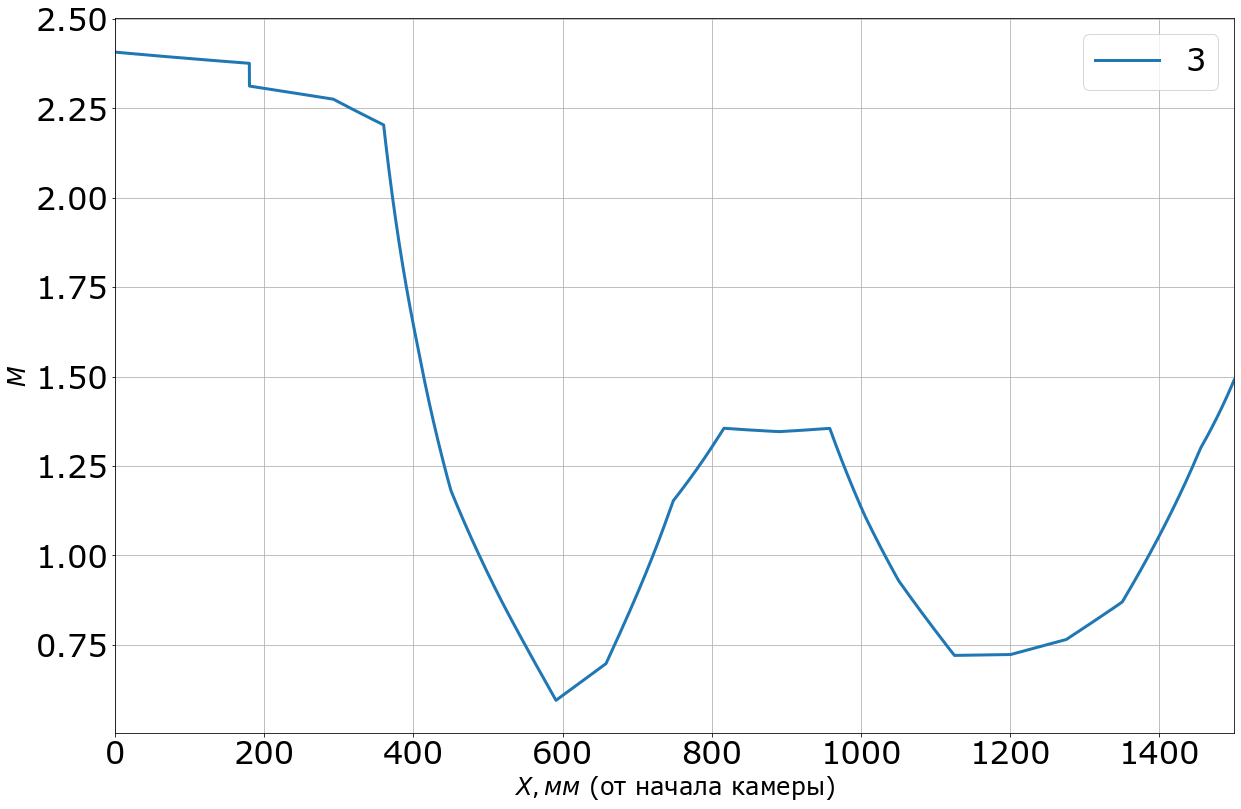

In [25]:
u = numpy.loadtxt('u_hot_regime_run' + name_add + '.txt')
#u_cold = numpy.loadtxt('result_without_burn'+name_add+'.txt')
#u_cold_burn = numpy.loadtxt('result_cold_burn'+name_add+'.txt')
pyplot.figure(figsize=(18, 12))
pyplot.grid(True)
pyplot.xlim(0, 1500)
#pyplot.plot(x * 1000 + change_zero_point, u_cold[1, :] / (1.3 * 287 * u_cold[2, :])**0.5, lw=3, label='1')
#pyplot.plot(x * 1000 + change_zero_point, u_cold_burn[1, :] / (1.3 * 287 * u_cold_burn[2, :])**0.5, lw=3, label='2')
pyplot.plot(x * 1000 + change_zero_point, u[1, :] / (1.3 * u[0, :] / u[3, :])**0.5, lw=3, label='3')
pyplot.xlabel('$X, мм$ (от начала камеры)', fontsize=24)
pyplot.ylabel('$M $', fontsize=24)
pyplot.legend(loc='best')
pyplot.tight_layout()
pyplot.savefig('M(x)_burn_cold_regime_run' + name_add + '.png')

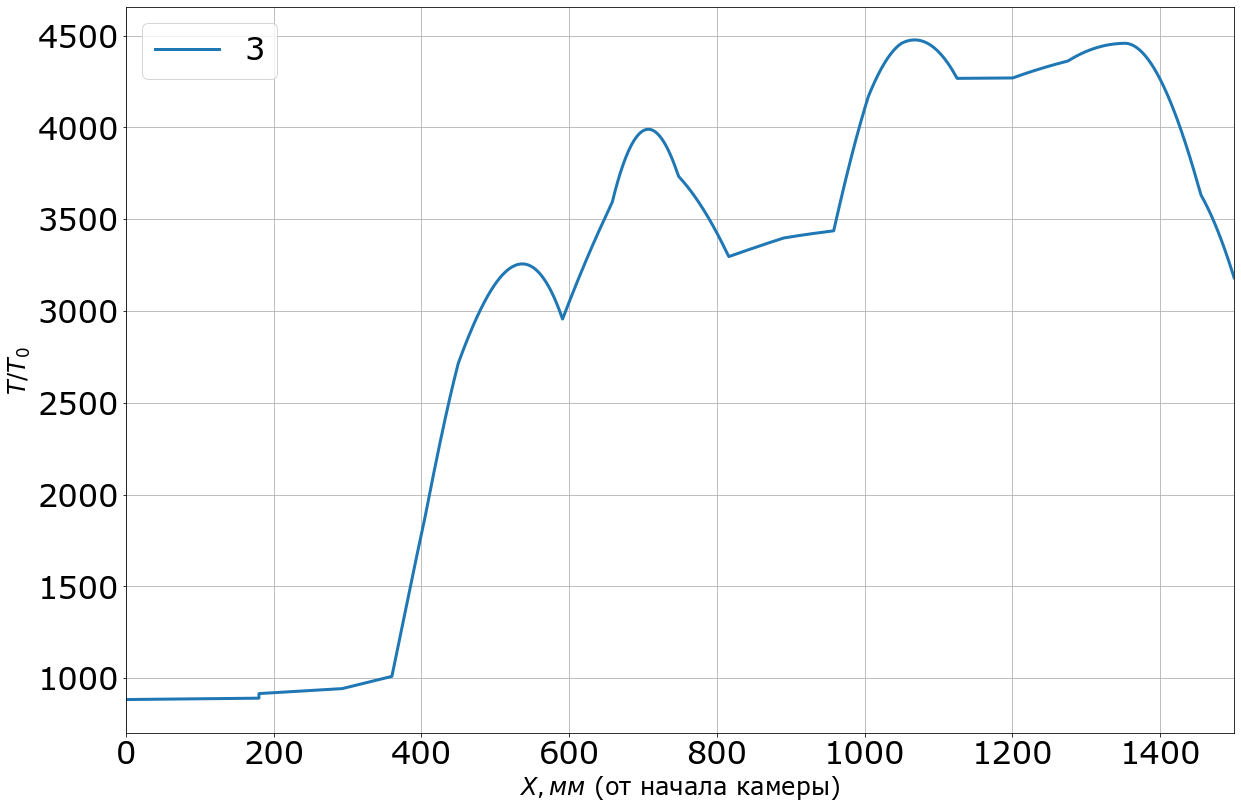

In [26]:
pyplot.figure(figsize=(18, 12))
pyplot.grid(True)
pyplot.xlim(0, 1500)
#pyplot.plot(x * 1000 + change_zero_point, u_cold[2, :] / T_0_cam, lw=3, label='1')
#pyplot.plot(x * 1000 + change_zero_point, u_cold_burn[2, :] / T_0_cam, lw=3, label='2')
pyplot.plot(x * 1000 + change_zero_point, u[2, :] / T_0_cam, lw=3, label='3')
pyplot.xlabel('$X, мм$ (от начала камеры)', fontsize=24)
pyplot.ylabel('$Т/T_0$', fontsize=24)
pyplot.legend(loc='best')
pyplot.tight_layout()
pyplot.savefig('T(x)_burn_cold_regime_run_' + name_add + '.png')

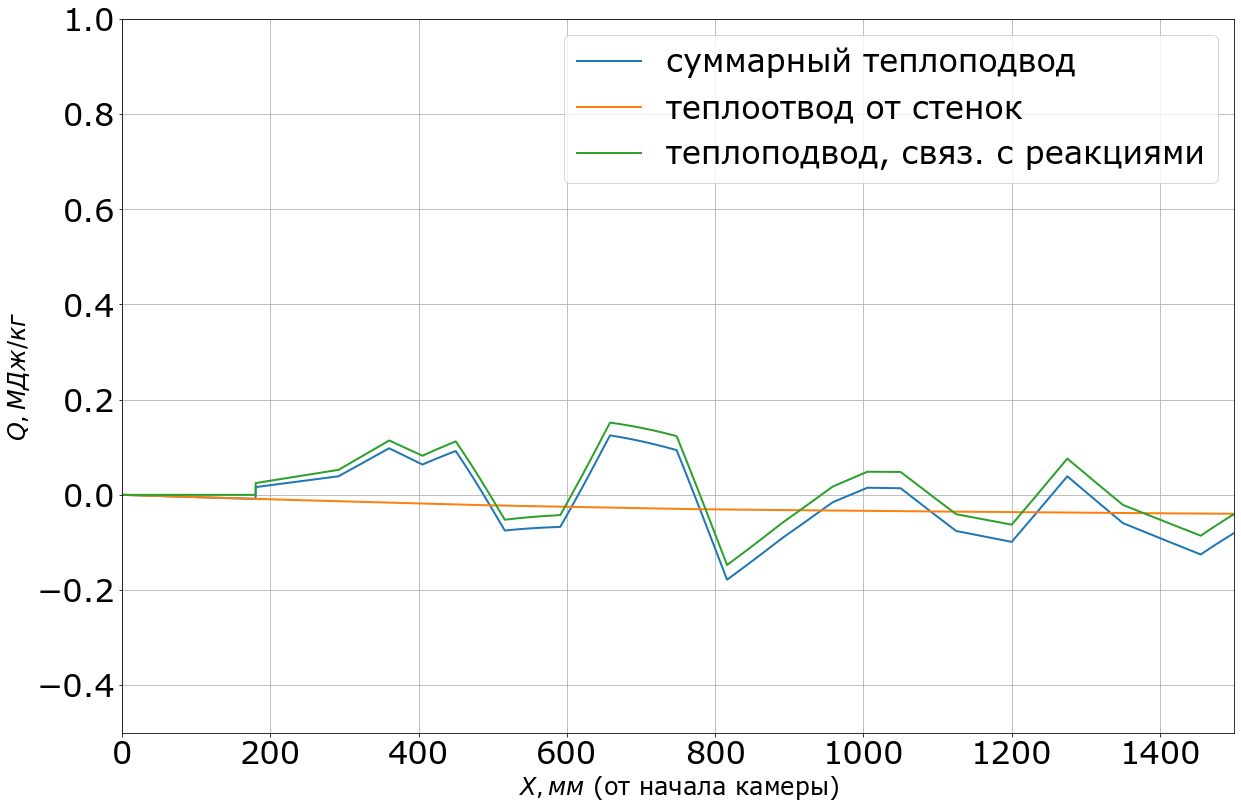

In [27]:
Q_without_burn = numpy.loadtxt('Q(x)_cold_burn' + name_add + '.txt')
#q_cc = numpy.loadtxt('q_cc(x).txt')
#print(max(Q))
pyplot.figure(figsize=(18, 12))
pyplot.grid(True)
pyplot.xlim(0, 1500)
pyplot.ylim(-0.5, 1.0)
#pyplot.plot(x, u[1, :] / (1.3 * 287 * u[2, :]) ** 0.5)
#pyplot.plot(x, Q_add[:]/10**7)
#HU_test=numpy.zeros_like(x)
#HU_test[1:]+=0.5* Hu / (1 + 2.7*14.5) * (Q_add[1:] - Q_add[:-1]) / h
#pyplot.plot(x, HU_test)
#u1=numpy.loadtxt('results_no_injection')
#pyplot.plot(x, u1[1, :] / (1.3 * 287 * u[2, :]) ** 0.5)
#pyplot.plot(x, u[2,:])
pyplot.xlabel('$X, мм$ (от начала камеры)', fontsize=24)
pyplot.ylabel('$Q, MДж/кг$', fontsize=24)

pyplot.plot(x * 1000 + change_zero_point, Q_without_burn[0] * 1e-6, lw=2, label='суммарный теплоподвод')
pyplot.plot(x * 1000 + change_zero_point, Q_without_burn[1] * 1e-6, lw=2, label='теплоотвод от стенок')
pyplot.plot(x * 1000 + change_zero_point, Q_without_burn[2] * 1e-6, lw=2, label='теплоподвод, связ. с реакциями')
pyplot.legend(loc='best')
#pyplot.plot(x, -622 * u[1, :] * u[3, :] * ((1 - .3/2*u[1, :]**2 / (1.3 * 287 * u[2, :]))* u[2, :] - 800) * Q[3])
#pyplot.plot(x, - 2.5e7 * Q[3])
#pyplot.plot(x, - 1.18e5*x**(4/5))
#pyplot.plot(x_cc, q_cc)
#pyplot.plot(x, Q[0] - Q[1])
pyplot.tight_layout()
pyplot.savefig('Q(x)_cold_hot_regime_run_' + name_add + '.png')

NameError: name 'u_cold' is not defined

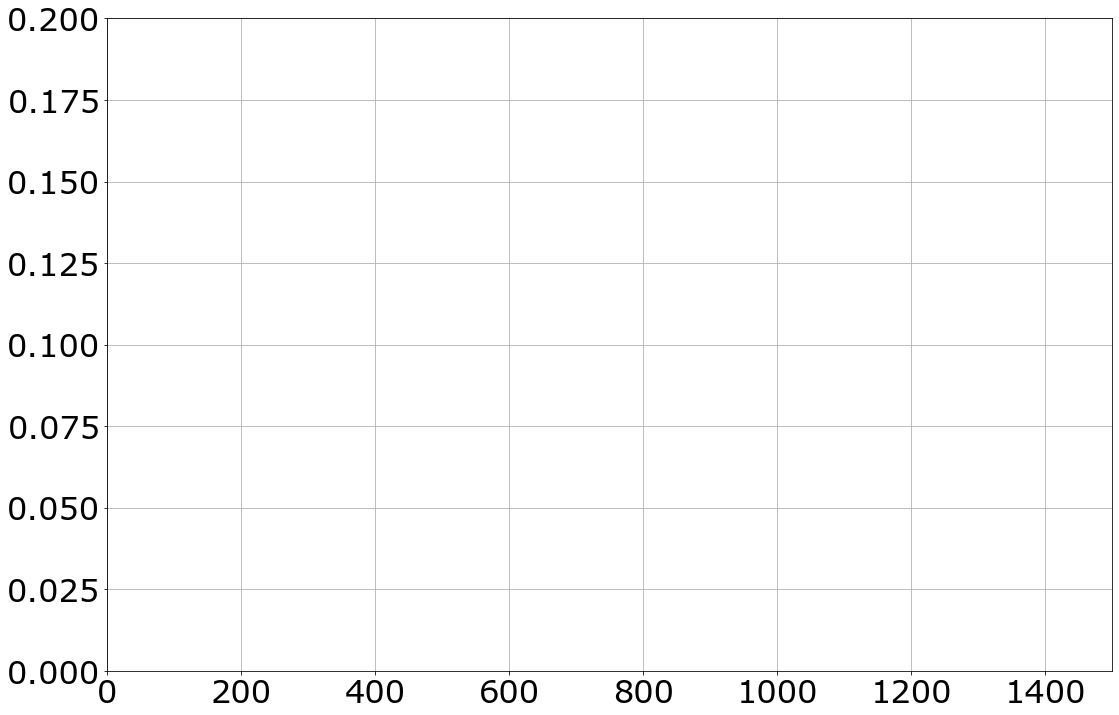

In [28]:
pyplot.figure(figsize=(18, 12))
pyplot.grid(True)
pyplot.xlim(0, 1500)
pyplot.ylim(0, 0.2)
pyplot.plot(x * 1000 + change_zero_point, u_cold[0, :] / P_0_cam, lw=3, label='холодный режим')
pyplot.plot(x[9849:] * 1000 + change_zero_point[9849:], P_ave / P_0_cam, lw=3, label='эксперимент')
pyplot.xlabel('$X, мм$ (от начала камеры)', fontsize=24)
pyplot.ylabel('$P/P_0$', fontsize=24)
pyplot.legend(loc='best')
pyplot.tight_layout()
pyplot.savefig('P(x)_cold_regime_run_' + name_add + '.png')

In [ ]:
def f_spatial(u, a, h, SS):
        #WENO coefficients for stencils
        d0 = 0.1
        d1 = 0.6
        d2 = 0.3
        #WENO coefficients for values
        a01 =  2.0/6.0
        a02 = -7.0/6.0
        a03 = 11.0/6.0
        a11 = -1.0/6.0
        a12 =  5.0/6.0
        a13 =  2.0/6.0
        a21 =  2.0/6.0
        a22 =  5.0/6.0
        a23 = -1.0/6.0
        eps_w = 1e-20
        E = numpy.zeros(len(u) - 5)
        E_plus = numpy.zeros_like(E)
        E_minus = numpy.zeros_like(E)
        IS1_plus = numpy.zeros_like(E)
        IS2_plus = numpy.zeros_like(E)
        IS3_plus = numpy.zeros_like(E)
        sigma1_plus = numpy.zeros_like(E)
        sigma2_plus = numpy.zeros_like(E)
        sigma3_plus = numpy.zeros_like(E)
        IS1_minus = numpy.zeros_like(E)
        IS2_minus = numpy.zeros_like(E)
        IS3_minus = numpy.zeros_like(E)
        sigma1_minus = numpy.zeros_like(E)
        sigma2_minus = numpy.zeros_like(E)
        sigma3_minus = numpy.zeros_like(E)
        w1_plus = numpy.zeros_like(E)
        w2_plus = numpy.zeros_like(E)
        w3_plus = numpy.zeros_like(E)
        w1_minus = numpy.zeros_like(E)
        w2_minus = numpy.zeros_like(E)
        w3_minus = numpy.zeros_like(E)
        if SS == 1:
            return 0.5*a/h*(u[4:-2] - u[2:-4])
        
        elif SS == 2:
            return 1/12*a/h*(8*(u[4:-2] - u[2:-4]) - u[5:-1] + u[1:-5])
        
        elif SS == 3:
            return a/h*(u[3:-3] - u[2:-4])
        
        elif SS == 4:
            E_plus[:] = d0 * (a01*u[:-5] + a02*u[1:-4] + a03*u[2:-3])\
            + d1 * (a11*u[1:-4] + a12*u[2:-3] + a13*u[3:-2])\
            + d2 * (a21*u[2:-3] + a22*u[3:-2] + a23*u[4:-1])                    
            E_minus[:] = d2 * (a23*u[1:-4] + a22*u[2:-3] + a21*u[3:-2])\
            + d1 * (a13*u[2:-3] + a12*u[3:-2] + a11*u[4:-1])\
            + d0 * (a03*u[3:-2] + a02*u[4:-1] + a01*u[5:])                    
            E[:] = 0.5 * (2*E_plus[:])# + E_minus[:])            
            return a/h*(E[1:] - E[:-1])
        
        elif SS == 5:
            return 0.5*a/h*(3*u[3:-3] - 4*u[2:-4] + u[1:-5])
        
        elif SS == 6:
            IS1_plus[:] = 13/12 * (u[:-5] - 2*u[1:-4] + u[2:-3])**2 + \
            0.25*(u[:-5] - 4*u[1:-4] + 3*u[2:-3])**2
            IS2_plus[:] = 13/12 * (u[1:-4] - 2*u[2:-3] + u[3:-2])**2 + \
            0.25*(u[1:-4] - u[3:-2])**2
            IS3_plus[:] = 13/12 * (u[4:-1] - 2*u[3:-2] + u[2:-3])**2 + \
            0.25*(u[4:-1] - 4*u[3:-2] + 3*u[2:-3])**2
            sigma1_plus[:] = d0 / (eps_w + IS1_plus[:])**2
            sigma2_plus[:] = d1 / (eps_w + IS2_plus[:])**2
            sigma3_plus[:] = d2 / (eps_w + IS3_plus[:])**2
            w1_plus[:] = sigma1_plus[:] / (sigma1_plus[:] + sigma2_plus[:] + sigma3_plus[:])
            #print(w1_plus[:])
            #numpy.savetxt('w1_plus.txt', w1_plus[:])
            w2_plus[:] = sigma2_plus[:] / (sigma1_plus[:] + sigma2_plus[:] + sigma3_plus[:])
            #numpy.savetxt('w2_plus.txt', w2_plus[:])
            w3_plus[:] = sigma3_plus[:] / (sigma1_plus[:] + sigma2_plus[:] + sigma3_plus[:])
            #numpy.savetxt('w3_plus.txt', w3_plus[:])
            E_plus[:] = w1_plus[:] * (a01*u[:-5] + a02*u[1:-4] + a03*u[2:-3])\
            + w2_plus[:] * (a11*u[1:-4] + a12*u[2:-3] + a13*u[3:-2])\
            + w3_plus[:] * (a21*u[2:-3] + a22*u[3:-2] + a23*u[4:-1]) 
            
            IS1_minus[:] = 13/12 * (u[1:-4] - 2*u[2:-3] + u[3:-2])**2 + \
            0.25*(u[1:-4] - 4*u[2:-3] + 3*u[3:-2])**2
            IS2_minus[:] = 13/12 * (u[2:-3] - 2*u[3:-2] + u[4:-1])**2 + \
            0.25*(u[2:-3] - u[4:-1])**2
            IS3_minus[:] = 13/12 * (u[5:] - 2*u[4:-1] + u[3:-2])**2 + \
            0.25*(u[5:] - 4*u[4:-1] + 3*u[3:-2])**2
            
            sigma1_minus[:] = d2 / (eps_w + IS1_minus[:])**2
            sigma2_minus[:] = d1 / (eps_w + IS2_minus[:])**2
            sigma3_minus[:] = d0 / (eps_w + IS3_minus[:])**2
            w1_minus[:] = sigma1_minus[:] / (sigma1_minus[:] + sigma2_minus[:] + sigma3_minus[:])
            w2_minus[:] = sigma2_minus[:] / (sigma1_minus[:] + sigma2_minus[:] + sigma3_minus[:])
            w3_minus[:] = sigma3_minus[:] / (sigma1_minus[:] + sigma2_minus[:] + sigma3_minus[:])
            E_minus[:] = w1_minus[:] * (a23*u[1:-4] + a22*u[2:-3] + a21*u[3:-2])\
            + w2_minus[:] * (a13*u[2:-3] + a12*u[3:-2] + a11*u[4:-1])\
            + w3_minus[:] * (a03*u[3:-2] + a02*u[4:-1] + a01*u[5:])                    
            E[:] = 0.5 * (2*E_plus[:]) #+ E_minus[:])            
            return a/h*(E[1:] - E[:-1])
        
        
        elif SS == 7:
            return 1/60*a/h*(45*(u[4:-2] - u[2:-4]) + 9*(u[1:-5] - u[5:-1]) + u[6:] - u[:-6])
        
        
        elif SS == 8:
            sigma = 0.5
            IS1_plus[:] = 13/12 * (u[:-5] - 2*u[1:-4] + u[2:-3])**2 + \
            0.25*(u[:-5] - 4*u[1:-4] + 3*u[2:-3])**2
            IS2_plus[:] = 13/12 * (u[1:-4] - 2*u[2:-3] + u[3:-2])**2 + \
            0.25*(u[1:-4] - u[3:-2])**2
            IS3_plus[:] = 13/12 * (u[4:-1] - 2*u[3:-2] + u[2:-3])**2 + \
            0.25*(u[4:-1] - 4*u[3:-2] + 3*u[2:-3])**2
            sigma1_plus[:] = d0 / (eps_w + IS1_plus[:])**2
            sigma2_plus[:] = d1 / (eps_w + IS2_plus[:])**2
            sigma3_plus[:] = d2 / (eps_w + IS3_plus[:])**2
            w1_plus[:] = sigma1_plus[:] / (sigma1_plus[:] + sigma2_plus[:] + sigma3_plus[:])
            #print(w1_plus[:])
            #numpy.savetxt('w1_plus.txt', w1_plus[:])
            w2_plus[:] = sigma2_plus[:] / (sigma1_plus[:] + sigma2_plus[:] + sigma3_plus[:])
            #numpy.savetxt('w2_plus.txt', w2_plus[:])
            w3_plus[:] = sigma3_plus[:] / (sigma1_plus[:] + sigma2_plus[:] + sigma3_plus[:])
            #numpy.savetxt('w3_plus.txt', w3_plus[:])
            E_plus[:] = w1_plus[:] * (a01*u[:-5] + a02*u[1:-4] + a03*u[2:-3])\
            + w2_plus[:] * (a11*u[1:-4] + a12*u[2:-3] + a13*u[3:-2])\
            + w3_plus[:] * (a21*u[2:-3] + a22*u[3:-2] + a23*u[4:-1]) 
            
          #  IS1_minus[:] = 13/12 * (u[1:-4] - 2*u[2:-3] + u[3:-2])**2 + \
          #  0.25*(u[1:-4] - 4*u[2:-3] + 3*u[3:-2])**2
          #  IS2_minus[:] = 13/12 * (u[2:-3] - 2*u[3:-2] + u[4:-1])**2 + \
          #  0.25*(u[2:-3] - u[4:-1])**2#
          #  IS3_minus[:] = 13/12 * (u[5:] - 2*u[4:-1] + u[3:-2])**2 + \
          #  0.25*(u[5:] - 4*u[4:-1] + 3*u[3:-2])**2
          #  
          #  sigma1_minus[:] = d2 / (eps_w + IS1_minus[:])**2
          #  sigma2_minus[:] = d1 / (eps_w + IS2_minus[:])**2
          #  sigma3_minus[:] = d0 / (eps_w + IS3_minus[:])**2
          #  w1_minus[:] = sigma1_minus[:] / (sigma1_minus[:] + sigma2_minus[:] + sigma3_minus[:])
          #  w2_minus[:] = sigma2_minus[:] / (sigma1_minus[:] + sigma2_minus[:] + sigma3_minus[:])
          #  w3_minus[:] = sigma3_minus[:] / (sigma1_minus[:] + sigma2_minus[:] + sigma3_minus[:])
          #  E_minus[:] = w1_minus[:] * (a23*u[1:-4] + a22*u[2:-3] + a21*u[3:-2])\
          #  + w2_minus[:] * (a13*u[2:-3] + a12*u[3:-2] + a11*u[4:-1])\
          #  + w3_minus[:] * (a03*u[3:-2] + a02*u[4:-1] + a01*u[5:])                    
            E[:] = 0.5 * (2*E_plus[:]) #+ E_minus[:])            
            F_upw = a/h*(E[1:] - E[:-1])
            F_cd4 = 1/12*a/h*(8*(u[4:-2] - u[2:-4]) - u[5:-1] + u[1:-5])
            
            return sigma * F_upw + (1 - sigma) * F_cd4

In [ ]:
def L_0(file_name, u_ex):
    u = numpy.loadtxt(file_name, skiprows=0)
    return max (abs(u[:,-1]-u_ex))

def L_2(file_name, u_ex, h):
    u = numpy.loadtxt(file_name, skiprows=0)
    return (sum((u[:,-1]-u_ex)**2*h))**0.5

In [ ]:
def L_0_RK6(file_name, u_ex):
    u = numpy.loadtxt(file_name, skiprows=0)
    return max (abs(u[:]-u_ex))

def L_2_RK6(file_name, u_ex, h):
    u = numpy.loadtxt(file_name, skiprows=0)
    return (sum((u[:]-u_ex)**2*h))**0.5

def fi_0(t):
    return 2 ** -0.5
def fi_1(t):
    return 6 ** 0.5 * t
def fi_2(t):
    return (6*t ** 2 - 0.5) * (5/2) ** 0.5
def fi_3(t):
    return (20*t ** 3 - 3*t) * (7/2) ** 0.5

In [ ]:
def OneD_conv_eq(file_name, Num_of_points, h, CFL, N_time_steps, SS, RK):
    """
    function which takes initial field and solves 1D convection equation
    
    file_name - file with values of initial field written in column
    Num_of_points - quantity of space points
    h - mesh spatial step
    CFL - stab coefficient. Defined as dt/h*a. Here a=1 and can be changed manually
    N_time_steps - number of time steps
    SS - space stencil. There are 5: 1 - CD2, 2 - CD4, 3 - Up-wind1, 4 - WENO5_optimal, 5 - Up-wind2, 6 - WENO5
    RK - type of time reconstruction. There are 3: 1 - Eu1, 2 - Eu2, 3 - Heun    
    
    """
    if SS == 1:            
        print('selected CD2')
    elif SS == 2:
        print('selected CD4')
    elif SS == 3:
        print('selected Up-wind1')
    elif SS == 4:
        print('selected WENO5_optimal')
    elif SS == 5:
        print('selected Up-wind2')
    elif SS == 6:
        print('selected WENO5')
    elif SS == 7:
        print('selected WENO5_symm')
    elif SS == 8:
        print('selected line combination CD4 and WENO5')
    else:
        print('wrong Space Stencil')
        stop 
    
    data = numpy.loadtxt(file_name, skiprows=0)
    
                
            
        
    if len(data) == Num_of_points:
        #print(data)
        #numpy.savetxt('result.txt', data)
        u = data.copy()
        u_res = numpy.zeros((Num_of_points, N_time_steps+1))
        u_res[:,0] = u[:]
        u_star = u.copy()
        u_dstar = u.copy()
        
        
        a = 1.
        dt = CFL * h / a
        #Teoretical solution
        #u = u_0(at - x)
        T = dt * N_time_steps
        u_ex = numpy.zeros(Num_of_points)
        delta = int(numpy.ceil(a*T / h))
        print(delta) 
        grid_ratio = int(numpy.ceil(Num_of_points / 3000))
        x = numpy.linspace(1480 * grid_ratio, 1520 * grid_ratio, num=40 * grid_ratio + 1)        
        #u_ex[23680+delta:24321+delta] = numpy.exp(0.625 - 1e5 / ((x[:]/16 - 1479.999999999999) * (x[:]/16 - 1519.999999999999))**2)
        u_ex[1480 * grid_ratio+delta:1520 * grid_ratio+1+delta] = numpy.sin((x[:]/grid_ratio - 1480) * numpy.pi / 40) ** 4
        numpy.savetxt('u_ex.txt', u_ex)        
        
        if RK == 1:
            print('selected Eu1')
            for i in range(1, N_time_steps+1):
                u_n = u.copy()                
                u[3:-3] = u_n[3:-3] - dt*f_spatial(u_n, a, h, SS)
                u_res[:,i] = u[:]
            numpy.savetxt('result.txt', u_res)
        elif RK == 2:
            print('selected Eu2')
            for i in range(1, N_time_steps+1):
                u_n = u.copy()
                
                u_star[3:-3] = u_n[3:-3] - 0.5*dt*f_spatial(u_n, a, h, SS)
                #numpy.savetxt('f_u_star', f_spatial(u_star, a, h, SS))
                u[3:-3] = u_n[3:-3] - dt*f_spatial(u_star, a, h, SS)
                u_res[:,i] = u[:]
            #numpy.savetxt('result.txt', u_res)
            numpy.savetxt('result.txt', u_res[:, -1])
        elif RK == 3:
            print('selected Heun')
            for i in range(1,N_time_steps+1):
                u_n = u.copy()          
                u_star[3:-3] = u_n[3:-3] - 1/3*dt*f_spatial(u_n, a, h, SS)
                u_dstar[3:-3] = u_n[3:-3] - 2/3*dt*f_spatial(u_star, a, h, SS)
                u[3:-3] = 0.25*u_n[3:-3] + 3/4*u_star[3:-3] - 3/4*dt*f_spatial(u_dstar, a, h, SS)
                u_res[:,i] = u[:]
            numpy.savetxt('result.txt', u_res[:, -1])
        elif RK == 6:
            print('selected RK6')
            k1 = u.copy()
            k2 = u.copy()
            k3 = u.copy()
            k4 = u.copy()
            k5 = u.copy()
            k6 = u.copy()
            k7 = u.copy() 
            for i in range(1,N_time_steps+1):
                u_n = u.copy()
                
            
                k1[3:-3] = -f_spatial(u_n, a, h, SS)
                k2[3:-3] = -f_spatial(u_n + dt*k1, a, h, SS)
                k3[3:-3] = -f_spatial(u_n + dt*(3*k1 + k2)/8, a, h, SS)
                k4[3:-3] = -f_spatial(u_n + dt*(8*k1 + 2*k2 + 8*k3)/27, a, h, SS)
                k5[3:-3] = -f_spatial(u_n + dt*(3*(3*21**0.5-7)*k1 - 8*(7-21**0.5)*k2 \
                            + 48*(7-21**0.5)*k3 - 3*(21-21**0.5)*k4)/392, a, h, SS)
                k6[3:-3] = -f_spatial(u_n + dt*(-5*(231+51*21**0.5)*k1 - 40*(7+21**0.5)*k2 \
                            - 320*21**0.5*k3 + 3*(21+121*21**0.5)*k4 + 392*(6+21**0.5)*k5)/1960, a, h, SS)
                k7[3:-3] = -f_spatial(u_n + dt*(15*(22+7*21**0.5)*k1 + 120*k2 + 40*(7*21**0.5-5)*k3\
                             - 63*(3*21**0.5-2)*k4 - 14*(49+9*21**0.5)*k5 + 70*(7-21**0.5)*k6)/180, a, h, SS)
                                
                u[3:-3] = u_n[3:-3] + dt * (9*k1[3:-3] + 64*k3[3:-3] + 49*k5[3:-3] + 49*k6[3:-3] + 9*k7[3:-3])/180
                u_res[:,i] = u[:]
            numpy.savetxt('result.txt', u_res[:, -1])
        elif RK == 7:
            print('selected RK7')
            k1 = u.copy()
            k2 = u.copy()
            k3 = u.copy()
            k4 = u.copy()
            k5 = u.copy()
            k6 = u.copy()
            k7 = u.copy() 
            k8 = u.copy() 
            k9 = u.copy() 
            for i in range(1,N_time_steps+1):
                u_n = u.copy()
                
            
                k1[3:-3] = -f_spatial(u_n, a, h, SS)
                k2[3:-3] = -f_spatial(u_n + dt*k1/6, a, h, SS)
                k3[3:-3] = -f_spatial(u_n + dt*k2/3, a, h, SS)
                k4[3:-3] = -f_spatial(u_n + dt*(k1 + 3*k3)/8, a, h, SS)
                k5[3:-3] = -f_spatial(u_n + dt*(148*k1 + 150*k3\
                            - 56*k4)/1331, a, h, SS)
                k6[3:-3] = -f_spatial(u_n + dt*(-404/243*k1 - 170/27*k3\
                            + 4024/1701*k4 + 10648/1701*k5), a, h, SS)
                k7[3:-3] = -f_spatial(u_n + dt*(2466/2401*k1 + 1242/343*k3\
                            - 19176/16807*k4 - 51909/16807*k5\
                            + 1053/2401*k6), a, h, SS)
                k8[3:-3] = -f_spatial(u_n + dt*(5/154*k1 + 96/539*k4\
                            - 1815/20384*k5 - 405/2464*k6 + 49/1144*k7), a, h, SS)
                k9[3:-3] = -f_spatial(u_n + dt*(-113/32*k1 - 195/22*k3\
                            + 32/7*k4 + 29403/3584*k5 - 729/512*k6\
                            +1029/1408*k7 + 21/16*k8), a, h, SS)
                                
                u[3:-3] = u_n[3:-3] + dt * (32/105*k4[3:-3] + 1771561/6289920*k5[3:-3]\
                        + 243/2560*k6[3:-3] + 16807/74880*k7[3:-3] + 77/1440*k8[3:-3] + 11/270*k9[3:-3])
                u_res[:,i] = u[:]
            numpy.savetxt('result.txt', u_res[:, -1])
            """""
        elif RK == 4:
            print('selected time_DG4')
            #Initial recontr
            alpha_0 = numpy.zeros_like(u)
            alpha_1 = numpy.zeros_like(u)
            alpha_2 = numpy.zeros_like(u)
            alpha_3 = numpy.zeros_like(u)
            u_initial = numpy.zeros_like(u)
            
            
            alpha_0[1480 * grid_ratio:1520 * grid_ratio+1] = 2/dt*func_sin_5_fi_0(x[:]/grid_ratio, dt)
            alpha_1[1480 * grid_ratio:1520 * grid_ratio+1] = 2/dt*func_sin_5_fi_1(x[:]/grid_ratio, dt)
            alpha_2[1480 * grid_ratio:1520 * grid_ratio+1] = 2/dt*func_sin_5_fi_2(x[:]/grid_ratio, dt)
            alpha_3[1480 * grid_ratio:1520 * grid_ratio+1] = 2/dt*func_sin_5_fi_3(x[:]/grid_ratio, dt)
            f_0 = fi_0(0)
            f_1 = fi_1(0)
            f_2 = fi_2(0)
            f_3 = fi_3(0)
           
            u_initial[:] = alpha_0[:]*f_0 + alpha_1[:]*f_1 + alpha_2[:]*f_2 + alpha_3[:]*f_3
            pyplot.xlim(1470, 1530)
            x = numpy.linspace(0, 3000, num=3001)
            pyplot.plot(x[1:], u_initial[:])
            pyplot.plot(x[1:], u_ex[:]);
            
            numpy.savetxt('result.txt', u_initial[:])
            """""
        else:
            print('wrong RK method')
            stop
        
        #print('L_0 =', L_0('result.txt', u_ex), ' ','L_2 =', L_2('result.txt', u_ex, h))
        print('L_0 =', L_0_RK6('result.txt', u_ex), ' ','L_2 =', L_2_RK6('result.txt', u_ex, h))
        
    else:
        print('wrong Number of values')
        stop

In [ ]:
OneD_conv_eq('example1.txt', 3000, 1, 1.0, 10, 8, 2)

In [ ]:
selected RK7

#CD4
L_0 = 0.0121867749915   L_2 = 0.0334174202987
L_0 = 0.000769326089649   L_2 = 0.00214274032192
L_0 = 4.82989265945e-05   L_2 = 0.000134729243505
L_0 = 3.02566079824e-06   L_2 = 8.43325037193e-06


#WENO5_optimal
L_0 = 0.00304685292514   L_2 = 0.00831603756865
L_0 = 0.000103619699305   L_2 = 0.000276722136525
L_0 = 3.28824509743e-06   L_2 = 8.73500178465e-06
L_0 = 1.03129947027e-07   L_2 = 2.73600536004e-07


#WENO5
L_0 = 0.0913851242651   L_2 = 0.193542524677
L_0 = 0.0757087240359   L_2 = 0.146748020556
L_0 = 0.0342586902408   L_2 = 0.0812842557659
L_0 = 0.022128957652   L_2 = 0.0485888806493
#WENO5 eps=1e-20
L_0 = 0.00970391257936   L_2 = 0.0262828171633
L_0 = 0.000425238733193   L_2 = 0.00117961541094
L_0 = 1.66210313197e-05   L_2 = 4.01018583904e-05
L_0 = 5.63517681296e-07   L_2 = 1.28409368266e-06

#CD6
L_0 = 0.000688107162604   L_2 = 0.00199554502377
L_0 = 1.13866686049e-05   L_2 = 3.27432936637e-05
L_0 = 1.80655529647e-07   L_2 = 5.17930864059e-07
L_0 = 2.83450496408e-09   L_2 = 8.11756280319e-09

In [ ]:
b2 = numpy.zeros(6000)
#b2[2960:3040] = 1
#b2[2960:3040] =numpy.sin((x2[2960:3040] - 1480) * numpy.pi / 40)
#b2[2960:3040] =numpy.sin((x2[2960:3040] - 1480) * numpy.pi / 40) ** 5
#b2[2960:3040] = numpy.exp(0.625 - 1e5 / ((x2[2960:3040] - 1479.999999999999) * (x2[2960:3040] - 1519.999999999999))**2)
b2[2960:3040] =numpy.sin((x2[2960:3040] - 1480) * numpy.pi / 40) ** 9
numpy.savetxt('example2.txt', b2)

In [ ]:
b3 = numpy.zeros(12000)
#b3[5919:6079] = 1
#b3[5920:6080] =numpy.sin((x3[5920:6080] - 1480) * numpy.pi / 40)
#b3[5920:6080] =numpy.sin((x3[5920:6080] - 1480) * numpy.pi / 40) ** 5
#b3[5920:6080] = numpy.exp(0.625 - 1e5 / ((x3[5920:6080] - 1479.999999999999) * (x3[5920:6080] - 1519.999999999999))**2)
b3[5920:6080] =numpy.sin((x3[5920:6080] - 1480) * numpy.pi / 40) ** 9
numpy.savetxt('example3.txt', b3)

In [ ]:
b4 = numpy.zeros(24000)
#b4[11840:12160] = 1
#b4[11840:12160] =numpy.sin((x4[11840:12160] - 1480) * numpy.pi / 40)
#b4[11840:12160] =numpy.sin((x4[11840:12160] - 1480) * numpy.pi / 40) ** 5
#b4[11840:12160] = numpy.exp(0.625 - 1e5 / ((x4[11840:12160] - 1479.999999999999) * (x4[11840:12160] - 1519.999999999999))**2)
b4[11840:12160] =numpy.sin((x4[11840:12160] - 1480) * numpy.pi / 40) ** 9
numpy.savetxt('example4.txt', b4)

In [ ]:
b5 = numpy.zeros(48000)
#b5[23680:24320] = 1
#b5[23680:24320] =numpy.sin((x5[23680:24320] - 1480) * numpy.pi / 40)
#b5[23680:24320] =numpy.sin((x5[23680:24320] - 1480) * numpy.pi / 40) ** 5
#b5[23680:24320] = numpy.exp(0.625 - 1e5 / ((x5[23680:24320] - 1479.999999999999) * (x5[23680:24320] - 1519.999999999999))**2)
b5[23680:24320] =numpy.sin((x5[23680:24320] - 1480) * numpy.pi / 40) ** 9
numpy.savetxt('example5.txt', b5)

In [ ]:
#Heun
#sin**2
#CD2
L_0 = 0.0425946708711   L_2 = 0.175363970511
L_0 = 0.0151451243822   L_2 = 0.0503230102012
L_0 = 0.0060335480087   L_2 = 0.0145883029811
L_0 = 0.00239935812939   L_2 = 0.00430708867317
L_0 = 0.000956109387703   L_2 = 0.00129477987224
L_0 = 0.000380057079328   L_2 = 0.000395050632289
#CD4
L_0 = 0.00534253566711   L_2 = 0.0160072855982
L_0 = 0.0017405795028   L_2 = 0.00400742346391
L_0 = 0.000587770380875   L_2 = 0.00106897108233
L_0 = 0.000207194043049   L_2 = 0.000291040010991
L_0 = 7.34033191696e-05   L_2 = 7.96207084098e-05
L_0 = 2.61016089964e-05   L_2 = 2.17891456622e-05
#WENO5_optimal
L_0 = 0.00655137801182   L_2 = 0.0182071920393
L_0 = 0.00210261298427   L_2 = 0.0044349259615
L_0 = 0.000697076960933   L_2 = 0.00115354044525
L_0 = 0.000233906432159   L_2 = 0.000307723528162
L_0 = 8.21064094381e-05   L_2 = 8.2898380727e-05
L_0 = 2.83896709655e-05   L_2 = 2.2430545427e-05
#WENO5
L_0 = 0.0464311101299   L_2 = 0.127345391648
L_0 = 0.0192206129918   L_2 = 0.0383450993872
L_0 = 0.00490089864693   L_2 = 0.00722781141085
L_0 = 0.00112427921479   L_2 = 0.00130624162031
L_0 = 0.000262496414826   L_2 = 0.000223877572371
L_0 = 5.46951066136e-05   L_2 = 3.23693397157e-05
#CD6
L_0 = 0.00634879005942   L_2 = 0.0174018974309
L_0 = 0.00204909078466   L_2 = 0.00427481597191
L_0 = 0.000686050137826   L_2 = 0.00112058668149
L_0 = 0.000229721869242   L_2 = 0.00030099831687
L_0 = 8.12017188004e-05   L_2 = 8.15424501975e-05
L_0 = 2.81172588991e-05   L_2 = 2.21600721632e-05

In [ ]:
#Heun
#sin**4
#CD2
L_0 = 0.0860895953815   L_2 = 0.309551552381
L_0 = 0.0220442349487   L_2 = 0.0801161045399
L_0 = 0.00551992304526   L_2 = 0.0201537945251
L_0 = 0.0013805370301   L_2 = 0.00504475988565
L_0 = 0.000345160869295   L_2 = 0.00126154014929
L_0 = 8.62912927762e-05   L_2 = 0.000315405575171
L_0 = 2.15727337571e-05   L_2 = 7.88526345536e-05
#CD4
L_0 = 0.00606356336858   L_2 = 0.0217426879433
L_0 = 0.000785535340188   L_2 = 0.00286102153036
L_0 = 9.88907688909e-05   L_2 = 0.000362414496288
L_0 = 1.23803938024e-05   L_2 = 4.55009923668e-05
L_0 = 1.54810043229e-06   L_2 = 5.69804369031e-06
L_0 = 1.93529093084e-07   L_2 = 7.12897499265e-07
L_0 = 2.41916449095e-08   L_2 = 8.91556053613e-08
#WENO5_optimal
L_0 = 0.00640647899961   L_2 = 0.0232557439012
L_0 = 0.000796983132565   L_2 = 0.00291643348682
L_0 = 9.92531607583e-05   L_2 = 0.000364383249286
L_0 = 1.23917496095e-05   L_2 = 4.55731347822e-05
L_0 = 1.54845552325e-06   L_2 = 5.70083391942e-06
L_0 = 1.9354019154e-07   L_2 = 7.13012542216e-07
L_0 = 2.41919879684e-08   L_2 = 8.91606608785e-08
#WENO5
L_0 = 0.0628254846471   L_2 = 0.162434003447
L_0 = 0.0191015205886   L_2 = 0.0339840016217
L_0 = 0.00131291233422   L_2 = 0.00196402581604
L_0 = 0.000101788753989   L_2 = 0.000121370910132
L_0 = 6.88023580495e-06   L_2 = 7.83644821522e-06
L_0 = 2.98276300721e-07   L_2 = 7.27452371356e-07
L_0 = 2.41927620159e-08   L_2 = 8.93177508484e-08
#CD6
L_0 = 0.00621540149939   L_2 = 0.0224507644023
L_0 = 0.000790481574707   L_2 = 0.00288621604596
L_0 = 9.90463829257e-05   L_2 = 0.000363306268586
L_0 = 1.23852629034e-05   L_2 = 4.55337771309e-05
L_0 = 1.5482526331e-06   L_2 = 5.6993188447e-06
L_0 = 1.93533848725e-07   L_2 = 7.12950397822e-07
L_0 = 2.41917922361e-08   L_2 = 8.91579426105e-08

In [ ]:
b6 = numpy.zeros(96000)
#b5[23680:24320] = 1
b6[47360:48640] =numpy.sin((x6[47360:48640] - 1480) * numpy.pi / 40) ** 4
numpy.savetxt('example6.txt', b6)

In [ ]:
b7 = numpy.zeros(192000)
#b5[23680:24320] = 1
b7[94720:97280] =numpy.sin((x7[94720:97280] - 1480) * numpy.pi / 40) ** 4
numpy.savetxt('example7.txt', b7)

In [ ]:
selected RK6
#CD6
L_0 = 6.84485430325e-06   L_2 = 1.99415970424e-05
L_0 = 1.13838814375e-07   L_2 = 3.2736929639e-07
L_0 = 1.80645132186e-09   L_2 = 5.17905458976e-09
L_0 = 2.83457701755e-11   L_2 = 8.11744528277e-11
"L_0" "=" 4.46309655899E-013 "L_2" "=" 1.2687427844E-012

#CD4
L_0 = 0.000119939940635   L_2 = 0.00033472712868
L_0 = 7.67986754346e-06   L_2 = 2.14275077968e-05
L_0 = 4.82934621071e-07   L_2 = 1.34729225993e-06
L_0 = 3.02564452381e-08   L_2 = 8.43325026902e-08
L_0 = 1.89194016009e-09   L_2 = 5.27276428252e-09

#WENO5_optimal
L_0 = 3.13486692231e-05   L_2 = 8.54660730814e-05
L_0 = 1.03734546253e-06   L_2 = 2.76999955391e-06
L_0 = 3.28839059316e-08   L_2 = 8.73535340861e-08
L_0 = 1.03130393114e-09   L_2 = 2.73601465008e-09
L_0 = 3.22564197575e-11   L_2 = 8.55488353924e-11

#WENO5
L_0 = 0.0012269789573   L_2 = 0.00269387235845
L_0 = 0.000139870027215   L_2 = 0.000332728897405
L_0 = 1.69182840231e-05   L_2 = 4.23200206825e-05
L_0 = 2.09392759265e-06   L_2 = 5.30822591073e-06
L_0 = 2.61187901973e-07   L_2 = 6.64085265655e-07

#WENO5
L_0 = 0.0134432474257   L_2 = 0.0270554574324
L_0 = 0.00156352228927   L_2 = 0.00336181068036
L_0 = 0.00022049428019   L_2 = 0.000430626547835
L_0 = 0.0002290051287   L_2 = 0.0002679965405
L_0 = 2.61187901973e-07   L_2 = 6.64085265655e-07

In [ ]:
#Step_func
#WENO5_optimal
L_0 = 0.431570933746   L_2 = 0.955289245362
L_0 = 0.443934698065   L_2 = 0.737826598277
L_0 = 0.453842825365   L_2 = 0.568923951706
#CD4
L_0 = 0.396437640595   L_2 = 0.929284618752
L_0 = 0.412833085603   L_2 = 0.722243046889
L_0 = 0.427153722911   L_2 = 0.559901613966
#WENO5_optimal_centr
L_0 = 0.437234216237   L_2 = 0.968136117982
L_0 = 0.447445416252   L_2 = 0.742905798371
L_0 = 0.456076673874   L_2 = 0.570821182077
#WENO5
L_0 = 0.529489772115   L_2 = 1.32435911688
L_0 = 0.54799515712   L_2 = 0.989964612001
L_0 = 0.544229894556   L_2 = 0.738888434222
L_0 = 0.520211567976   L_2 = 0.535409335475

#sin**1
#CD4
L_0 = 0.0411227698968   L_2 = 0.0695150131299
L_0 = 0.0248698683765   L_2 = 0.0314274258394
L_0 = 0.0149871863429   L_2 = 0.0142819984404
L_0 = 0.00899736403298   L_2 = 0.00650649965786
L_0 = 0.00538599871539   L_2 = 0.00296924273098
L_0 = 0.0032176145486   L_2 = 0.00135672104831
#WENO5
L_0 = 0.117404678482   L_2 = 0.253662193829
L_0 = 0.0565204771486   L_2 = 0.110086860438
L_0 = 0.0272304617859   L_2 = 0.0381970441034
L_0 = 0.0133354985868   L_2 = 0.012865553589
L_0 = 0.00676396292622   L_2 = 0.0043703639981
L_0 = 0.00343304143769   L_2 = 0.00153753194985
#WENO5_optimal
L_0 = 0.0440243245384   L_2 = 0.0775314309908
L_0 = 0.0260836551304   L_2 = 0.0341548107985
L_0 = 0.0154995397675   L_2 = 0.0152050652055
L_0 = 0.00921542851762   L_2 = 0.00681756546754
L_0 = 0.00547904161581   L_2 = 0.00307340818009
L_0 = 0.00325728422456   L_2 = 0.00139137179185
#WENO5_optimal_symm
L_0 = 0.0429608516781   L_2 = 0.0758197789935
L_0 = 0.0256022937488   L_2 = 0.0334349529085
L_0 = 0.0152825044002   L_2 = 0.014926210866
L_0 = 0.00911862632553   L_2 = 0.00671492289574
L_0 = 0.00543633817945   L_2 = 0.00303692164356
L_0 = 0.00323863491992   L_2 = 0.00137872198614

#sin**5
#CD4
L_0 = 0.00960783194008   L_2 = 0.0305750720544
L_0 = 0.00127072753977   L_2 = 0.00406328250781
L_0 = 0.000160555512744   L_2 = 0.000514041348396
L_0 = 2.01143237737e-05   L_2 = 6.44169618419e-05
L_0 = 2.51555368935e-06   L_2 = 8.05667209673e-06
L_0 = 3.14481506503e-07   L_2 = 1.00721801284e-06
#WENO5_optimal
L_0 = 0.0103175818204   L_2 = 0.0331287137378
L_0 = 0.00129582303214   L_2 = 0.00415276193448
L_0 = 0.000161356677308   L_2 = 0.000516907376027
L_0 = 2.0139467479e-05   L_2 = 6.45071402916e-05
L_0 = 2.51634016901e-06   L_2 = 8.05949740139e-06
L_0 = 3.14506089394e-07   L_2 = 1.00730641021e-06
#WENO5
L_0 = 0.0794186803662   L_2 = 0.214291310007
L_0 = 0.0209718499446   L_2 = 0.0404317429679
L_0 = 0.00106376702203   L_2 = 0.001556085788
L_0 = 4.50855808518e-05   L_2 = 8.02640539834e-05
L_0 = 2.51788520345e-06   L_2 = 8.11897626442e-06
L_0 = 3.14556468428e-07   L_2 = 1.00747813693e-06
#WENO5_optimal_symm
L_0 = 0.00992912822628   L_2 = 0.0317753499678
L_0 = 0.00128161375769   L_2 = 0.00410356347898
L_0 = 0.000160899851628   L_2 = 0.000515319163719
L_0 = 2.01251071222e-05   L_2 = 6.44570768232e-05
L_0 = 2.51589080935e-06   L_2 = 8.05792816427e-06
L_0 = 3.14492039744e-07   L_2 = 1.00725730589e-06

#exp
#CD4
L_0 = 0.0314286359555   L_2 = 0.0783213755251
L_0 = 0.010471693975   L_2 = 0.0213772087871
L_0 = 0.00237057071776   L_2 = 0.00435870796134
L_0 = 0.000391444120218   L_2 = 0.000685907349276
#WENO5_optimal
L_0 = 0.0364431495115   L_2 = 0.0922061436925
L_0 = 0.0117445091725   L_2 = 0.0239855707334
L_0 = 0.00266154590294   L_2 = 0.00466656541802
L_0 = 0.000415083570539   L_2 = 0.000707169634458
#WENO5
L_0 = 0.0694847822155   L_2 = 0.172583777508
L_0 = 0.0306213354703   L_2 = 0.0697760661872
L_0 = 0.0225387030596   L_2 = 0.0441614686077
L_0 = 0.0125049113511   L_2 = 0.024110010731
L_0 = 0.00671821248695   L_2 = 0.014153609528
#WENO5_optimal_symm
L_0 = 0.0349692461278   L_2 = 0.0876885378203
L_0 = 0.0113191563404   L_2 = 0.0229336285748
L_0 = 0.00258485864957   L_2 = 0.00452210794086
L_0 = 0.000407009159667   L_2 = 0.000696146963636


#sin_9
#CD2
L_0 = 0.249734920543   L_2 = 0.700662802874
L_0 = 0.0751894243669   L_2 = 0.204341070185
L_0 = 0.0188135946033   L_2 = 0.0522774038014
L_0 = 0.00468175750316   L_2 = 0.0131155440095
L_0 = 0.00116879743417   L_2 = 0.00328102586771

#CD4
L_0 = 0.0291392034671   L_2 = 0.0752258511218
L_0 = 0.00429205795351   L_2 = 0.0108993079771
L_0 = 0.000553322364547   L_2 = 0.00140110763449
L_0 = 6.95658241001e-05   L_2 = 0.000176076622274
L_0 = 8.70604140246e-06   L_2 = 2.20341399998e-05
L_0 = 1.08854238567e-06   L_2 = 2.75495936313e-06
#WENO5_opt
L_0 = 0.0323865489421   L_2 = 0.0856422404106
L_0 = 0.00446075522236   L_2 = 0.0113368377982
L_0 = 0.00055901124875   L_2 = 0.00141548774653
L_0 = 6.97459315334e-05   L_2 = 0.000176529885738
L_0 = 8.7116840557e-06   L_2 = 2.20483275439e-05
#WENO5
L_0 = 0.154526030838   L_2 = 0.36437252544
L_0 = 0.0363232399145   L_2 = 0.0681434431774
L_0 = 0.00151696474869   L_2 = 0.00255035285414
L_0 = 7.00606418823e-05   L_2 = 0.000177674112404
L_0 = 8.72197404544e-06   L_2 = 2.20698127554e-05
L_0 = 1.0890542308e-06   L_2 = 2.75607626827e-06

#CD6
L_0 = 0.0307312683892   L_2 = 0.0804822189715
L_0 = 0.00436665195859   L_2 = 0.0110990646221
L_0 = 0.000555777553752   L_2 = 0.00140753423258
L_0 = 6.96431390458e-05   L_2 = 0.00017627831663
L_0 = 8.70846063239e-06   L_2 = 2.20404473408e-05
L_0 = 1.08861800363e-06   L_2 = 2.75515649253e-06

In [ ]:
#RK6
#sin**9
#CD2
L_0 = 0.127285616376   L_2 = 0.391605839764
L_0 = 0.0411198098988   L_2 = 0.12733461666
L_0 = 0.00125217577674   L_2 = 0.0033303356838
L_0 = 0.000340449365724   L_2 = 0.000870861971701
#CD4
L_0 = 0.110572316685   L_2 = 0.350846006911
L_0 = 0.0368044521755   L_2 = 0.116825642379
L_0 = 0.000237271516637   L_2 = 0.000582295907151
L_0 = 0.00011955754704   L_2 = 0.000293394203601
#WENO5_optimal
L_0 = 0.110003840464   L_2 = 0.349750791293
L_0 = 0.0367713224947   L_2 = 0.116755349325
L_0 = 0.000237068027757   L_2 = 0.000581911033764
L_0 = 0.000119551168253   L_2 = 0.000293383583684
#WENO5
L_0 = 0.116055424479   L_2 = 0.34923549142
L_0 = 0.0369950126256   L_2 = 0.116681683442
L_0 = 0.000347951618191   L_2 = 0.000819824659138
L_0 = 0.000134327219808   L_2 = 0.000322255883411
#CD6
L_0 = 0.110141569909   L_2 = 0.349789987489
L_0 = 0.0367675798106   L_2 = 0.116755869032
L_0 = 0.000237273820753   L_2 = 0.000582260589317
L_0 = 0.000119557618143   L_2 = 0.000293394534653

In [ ]:
#Heun
#sin**3
#CD2
L_0 = 0.0586233638125   L_2 = 0.231837847945
L_0 = 0.0143818259699   L_2 = 0.0599099001867
L_0 = 0.00359394594343   L_2 = 0.0151469170632
L_0 = 0.000899198824547   L_2 = 0.00380599170305
L_0 = 0.000224831797714   L_2 = 0.000954083683012
L_0 = 5.62095107257e-05   L_2 = 0.000238897530656
#CD4
L_0 = 0.00324964276181   L_2 = 0.0150550263655
L_0 = 0.000634672967909   L_2 = 0.0021188127859
L_0 = 0.000138857001785   L_2 = 0.000298431808845
L_0 = 2.96808628936e-05   L_2 = 4.30574939319e-05
L_0 = 6.28991443834e-06   L_2 = 6.39485359781e-06
L_0 = 1.32811962549e-06   L_2 = 9.75178029091e-07
#WENO5_optimal
L_0 = 0.00364602457528   L_2 = 0.0161149298494
L_0 = 0.000692404814015   L_2 = 0.0021949947361
L_0 = 0.0001455748787   L_2 = 0.000306064489274
L_0 = 3.05710225439e-05   L_2 = 4.39598611323e-05
L_0 = 6.41640111347e-06   L_2 = 6.50567201936e-06
L_0 = 1.34665928106e-06   L_2 = 9.88690599986e-07
#WENO5
L_0 = 0.0760241579564   L_2 = 0.189616208777
L_0 = 0.0129554014416   L_2 = 0.0270594079813
L_0 = 0.0019199522229   L_2 = 0.00299764467805
L_0 = 0.00024277106247   L_2 = 0.000278509014885
L_0 = 2.58144112278e-05   L_2 = 2.15515227267e-05
L_0 = 3.72436459879e-06   L_2 = 2.31881379036e-06
#CD6
L_0 = 0.00347142933202   L_2 = 0.0155877402671
L_0 = 0.000669173517295   L_2 = 0.00215828701398
L_0 = 0.000142271836302   L_2 = 0.000302467251123
L_0 = 3.00804622174e-05   L_2 = 4.35353572306e-05
L_0 = 6.34250797824e-06   L_2 = 6.45324687236e-06
L_0 = 1.33550660448e-06   L_2 = 9.82257051507e-07

In [ ]:
#EU1_Upwind2
L_0 = 0.526749731754   L_2 = 1.42228485724
L_0 = 0.233418652713   L_2 = 0.565799264085
L_0 = 0.100033195039   L_2 = 0.241879424968
L_0 = 0.0463362311101   L_2 = 0.11288720235
#EU2_Upwind2
L_0 = 0.254375183232   L_2 = 0.721940795914
L_0 = 0.0830964116938   L_2 = 0.227183243936
L_0 = 0.0211738473846   L_2 = 0.0587962805926
L_0 = 0.00527108058735   L_2 = 0.0147590035003

In [ ]:
OneD_conv_eq('example1.txt', 3000, 1, 1., 100, 6, 3)

In [ ]:
OneD_conv_eq('example1.txt', 3000, 1, 1., 100, 1, 3)

In [ ]:
OneD_conv_eq('example1.txt', 3000, 1, 1., 100, 6, 3)



In [ ]:
print(x[0:10])
pyplot.xlim(1470, 1530)
pyplot.plot(x[1:], b[:]);

In [ ]:
x = numpy.linspace(0, 3000, num=3001)
x2 = numpy.linspace(0, 3000, num=6001)
x3 = numpy.linspace(0, 3000, num=12001)
x4 = numpy.linspace(0, 3000, num=24001)
x5 = numpy.linspace(0, 3000, num=48001)
x6 = numpy.linspace(0, 3000, num=96001)
x7 = numpy.linspace(0, 3000, num=192001)

In [ ]:
b = numpy.zeros(3000)
#b[1479:1519] = 1
#b[1480:1520] = numpy.sin((x[1480:1520] - 1480) * numpy.pi / 40)
#b[1480:1520] = numpy.sin((x[1480:1520] - 1480) * numpy.pi / 40) ** 5
#b[1480:1521] = numpy.exp(0.625 - 1e5 / ((x[1480:1521] - 1479.999999999999) * (x[1480:1521] - 1519.999999999999))**2)
b[1480:1520] = numpy.sin((x[1480:1520] - 1480) * numpy.pi / 40) ** 0
numpy.savetxt('example1.txt', b)
print(max(b))

In [ ]:
def func_sin_5_fi_0(x, tau):
    return 2**-0.5 /6/numpy.pi * (-150 * numpy.cos(numpy.pi/40*(x-tau))+\
           25*numpy.cos(3*numpy.pi/40*(x-tau))-3*numpy.cos(numpy.pi/8*(x-tau))+\
           150*numpy.cos(numpy.pi*x/40)-25*numpy.cos(3*numpy.pi*x/40)+\
           3*numpy.cos(numpy.pi*x/8))

In [ ]:
def func_sin_5_fi_1(x, tau):
    P = numpy.pi
    from numpy import cos, sin
    return 1/tau*(-9.74621*tau*cos(P*x/40) + 1.62437*tau*cos(3*P*x/40)\
           -0.194924*tau*cos(P*x/8) - 1.62437*tau*cos(3/40*P*(-1480+x-tau))\
            +248.185*sin(P*x/40) - 13.7881*sin(3*P*x/40) + 0.992741*sin(P*x/8)\
            +13.7881*sin(3/40*P*(x-tau)) - 0.992741*sin(P/8*(x-tau)) -\
            248.185*sin(P/40*(1480-x+tau)) + 0.194924*tau*sin(P/8*(1484-x+tau))\
            +9.74621*tau*sin(P/40*(1500-x+tau)))

In [ ]:
def func_sin_5_fi_2(x, tau):
    P = numpy.pi
    from numpy import cos, sin
    return tau**-2 * ((-24477.2+12.5823*tau**2)*cos(P*x/40) + \
           (453.281-2.09705*tau**2)*cos(3*P*x/40) - \
           19.5818*(cos(P*x/8) - cos(P*(x-tau)/8)) + 24477.2*cos(P*(x-tau)/40)\
           -453.281*cos(3*P*(x-tau)/40) + tau*(tau*(0.251646*cos(P*x/8) - \
           12.5823*cos(P*(x-tau)/40) + 2.09705*cos(3*P*(x-tau)/40) - \
           0.251646*cos(P*(x-tau)/8)) - 961.217*(sin(P*x/40) + sin(P*(x-tau)/40))\
           +53.401*(sin(3*P*x/40) + sin(3*P*(x-tau)/40)) - 3.84487*(sin(P*x/8)\
           +sin(P*(x-tau)/8))))

In [ ]:
def func_sin_5_fi_3(x, tau):
    P = numpy.pi
    from numpy import cos, sin
    return 1/tau**3*(tau*(144809 - 14.8876*tau**2)*cos(P*x/40) + \
           tau*(-2681.65 + 2.48126*tau**2)*cos(3*P*x/40) - \
           3.68753*10**6*sin(P*x/40) + 22762.5*sin(3*P*x/40) - 590.005*sin(P*x/8)\
           + 3.68753*10**6*sin(1/40*P*(x - tau)) - 22762.5*sin(3/40*P*(x - tau)) + \
           tau*((115.847 - 0.297752*tau**2)*cos(P*x/8) + (144809 - \
           14.8876*tau**2)*cos(P/40*(x - tau)) - 2681.65*cos(3/40*P*(x - tau))\
           + 115.847*cos(P/8*(x - tau)) + tau*(2.48126*tau*cos(3/40*P*(x - tau)) - \
           0.297752*tau*cos(P/8*(x - tau)) + 2274.65*sin(P*x/40) - 126.37*sin(3*P*x/40)\
           + 9.09862*sin(P*x/8) - 2274.65*sin(P/40*(x - tau)) + \
           126.37*sin(3/40*P*(x - tau)) - 9.09862*sin(P/8*(x - tau)))) + \
           590.005*sin(P/8*(x - tau)))

In [ ]:
pyplot.figure(figsize=(14, 12))
pyplot.grid(True)
#a = numpy.loadtxt('WENO5opt_centr_Heun.txt')
#c = numpy.loadtxt('Heun_WENO5_opt_sin_1.txt')
d = numpy.loadtxt('u_ex.txt')
#e = numpy.loadtxt('Up-wind_Heun.txt')
#f = numpy.loadtxt('WENO5_opt_Heun.txt')
#g = numpy.loadtxt('Heun_CD4_exp.txt')
#j = numpy.loadtxt('Up-wind_Heun.txt')
#k = numpy.loadtxt('Up-wind2_Heun.txt')
#l = numpy.loadtxt('Heun_WENO5_opt_sin_5.txt')

m = numpy.loadtxt('result.txt')
print(d.shape)

#print(x)
pyplot.xlabel(' х')
pyplot.ylabel(' $u$')
pyplot.tight_layout()
pyplot.xlim(1300, 1630)
pyplot.ylim(-0.04, 1.5)

#pyplot.plot(x[:-1], d[:], label='точное решение', color='black')


#pyplot.plot(x[1:], e[:,-1], label='Up-wind')
#pyplot.plot(x[1:], f[:,-1], label='ЦР-2')
#pyplot.plot(x[:-1], g[:,-1], label='ЦР-4')
#pyplot.plot(x[:-1], c[:,-1], label='WENO5opt')
pyplot.plot(x[:-1], m[:], label='line comb')
#pyplot.plot(x[1:], a[:,-1], label='WENO5 в симм. постановке')

#pyplot.plot(x[1:], f[:,-1], label='WENO5 c опт. весами')
#pyplot.plot(x[:-1], m[:,-1], label='WENO5')
#pyplot.plot(x[1:], k[:,-1], label='Upwind2')
#pyplot.plot(x[1:], j[:,-1], label='Upwind1')
pyplot.plot(x[1:], b[:], '--', label='Начальное состояние',  color='grey')

pyplot.legend(loc='best', fontsize='medium')
pyplot.savefig('Heun_WENO_exp.png');
#pyplot.plot(x[1:], a[:,-1] - c[:,-1]);